In [1]:
from fits_metadata_ex import create_fits_csv

In [2]:
path = r"C:\Home_items\fitscollection"
file_path = r"C:\Home_items\moc_astro\metadata_set.csv"

In [3]:
from astropy.io import fits
f = r"C:\Home_items\fitscollection\G351.632-0.459_atlasgal.fits"
with fits.open(f) as hdul:
    print(repr(hdul[0].header))


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  123                                                  
NAXIS2  =                   68                                                  
EXTEND  =                    T                                                  
CRVAL1  =                  0.0                                                  
CRVAL2  =                 -0.0                                                  
CRPIX1  =              -4952.0                                                  
CRPIX2  =                312.0                                                  
CDELT1  =         -0.001666667                                                  
CDELT2  =          0.001666667                                                  
CTYPE1  = 'GLON-CAR'        

In [4]:
wcs = WCS(hdul[0].header, naxis=2)
wcs_celestial = wcs.celestial
print("CRVAL after slice:", wcs_celestial.wcs.crval)


NameError: name 'WCS' is not defined

In [5]:
table = create_fits_csv(path,file_path)

Error processing whsky072.fit: ERROR 5 in wcsset() at line 2804 of file cextern\wcslib\C\wcs.c:
Invalid parameter value.
ERROR 2 in spcspxe() at line 986 of file cextern\wcslib\C\spc.c:
Missing required rest frequency or wavelength.

CSV file created: C:\Home_items\moc_astro\metadata_set.csv


In [6]:
import csv
from mocpy import MOC

def load_mocs_from_csv(csv_path, moc_column="MOC"):
    """
    Reads MOC text strings from a CSV, parses them into MOC objects, and returns a list.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file created by 'create_fits_csv'.
    moc_column : str, optional
        Name of the column containing the MOC strings (default 'MOC').

    Returns
    -------
    list of MOC or None
        Each entry corresponds to one row in the CSV. If the MOC cannot be parsed,
        we store None for that row.
    """
    moc_list = []
    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            moc_str = row.get(moc_column, "")
            if moc_str and moc_str.strip() != "None":
                try:
                    # Convert from text syntax: e.g. "10/6975313 10/6975314"
                    moc_obj = MOC.from_string(moc_str)
                    moc_list.append(moc_obj)
                except Exception as e:
                    print(f"Could not parse MOC string '{moc_str}': {e}")
                    moc_list.append(None)
            else:
                # No valid MOC in this row
                moc_list.append(None)
    return moc_list



In [7]:
load_mocs_from_csv(file_path)

[10/6975313 ,
 10/6978163 6978169 ,
 10/8472269 ,
 6/28827 28830 
 7/115301-115303 115305 115312 115314-115315 115324 115326 115397 115408-115410 
 8/461119 461160 461162-461163 461199 461203 461229 461252 461254-461255 461272 
  461274-461275 461300 461302-461303 461308 461585 461597 461644 461648 
 9/1844471 1844475 1844619 1844644 1844646-1844647 1844664 1844666-1844667 
  1844791 1844795 1844807 1844811 1844871 1844876-1844877 1844879 
  1844912-1844913 1844915 1844924-1844925 1844927 1845012 1845014-1845015 
  1845064 1845066-1845067 1845092 1845094-1845095 1845112 1845114-1845115 
  1845204 1845206-1845207 1845236-1845238 1845240-1845242 1846336-1846337 
  1846339 1846348-1846349 1846351 1846384-1846385 1846387 1846396-1846397 
  1846399 1846580-1846582 1846584-1846586 1846596-1846598 1846600-1846602 
  1846656-1846657 1846659-1846662 1847944 1847946 
 10/7377879 7377883 7377895 7377899 7378475 7378488 7378490-7378491 7378580 
  7378582-7378583 7378632 7378634-7378635 7378660 737

In [8]:
import csv
from mocpy import MOC

def load_mocs_and_filenames(csv_path, moc_column="MOC", filename_column="FILENAME"):
    """
    Reads MOC text strings and filenames from a CSV, parses them into MOC objects,
    and returns a list of (moc_obj, filename).

    Parameters
    ----------
    csv_path : str
        Path to the CSV file created by 'create_fits_csv'.
    moc_column : str, optional
        Name of the column containing the MOC strings (default 'MOC').
    filename_column : str, optional
        Name of the column containing the filename (default 'FILENAME').

    Returns
    -------
    list of (MOC or None, str)
        Each entry is a tuple (moc_obj, filename). If the MOC cannot be parsed,
        moc_obj will be None, but filename will still be the CSV's filename column.
    """
    data = []
    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            moc_str = row.get(moc_column, "")
            fname = row.get(filename_column, "Unknown")

            if moc_str and moc_str.strip() != "None":
                try:
                    moc_obj = MOC.from_string(moc_str)
                    data.append((moc_obj, fname))
                except Exception as e:
                    print(f"Could not parse MOC string '{moc_str}': {e}")
                    data.append((None, fname))
            else:
                # No valid MOC in this row
                data.append((None, fname))
    return data


In [9]:
import matplotlib.pyplot as plt

def plot_moc_matplotlib(moc_obj, title="MOC Coverage"):
    """
    Plots a single MOC object using Matplotlib and the MOC's built-in WCS.

    Parameters
    ----------
    moc_obj : MOC
        A MOC object from the mocpy library.
    title : str
        Title of the plot.
    """
    fig = plt.figure(figsize=(8, 6))
    try:
        wcs = moc_obj.wcs(fig=fig)  # Build a WCS for the MOC coverage (mocpy >= 0.10)
    except AttributeError:
        print("Your mocpy is too old for moc_obj.wcs(fig=...). Please upgrade mocpy >= 0.10.")
        return

    ax = fig.add_subplot(111, projection=wcs)

    # Fill the MOC region with semi-transparent blue
    moc_obj.fill(ax=ax, wcs=wcs, alpha=0.4, color="blue")
    # Draw the MOC border in red
    moc_obj.border(ax=ax, wcs=wcs, alpha=1.0, color="red")

    ax.grid(True, ls=":")
    ax.set_title(title)

    plt.show()


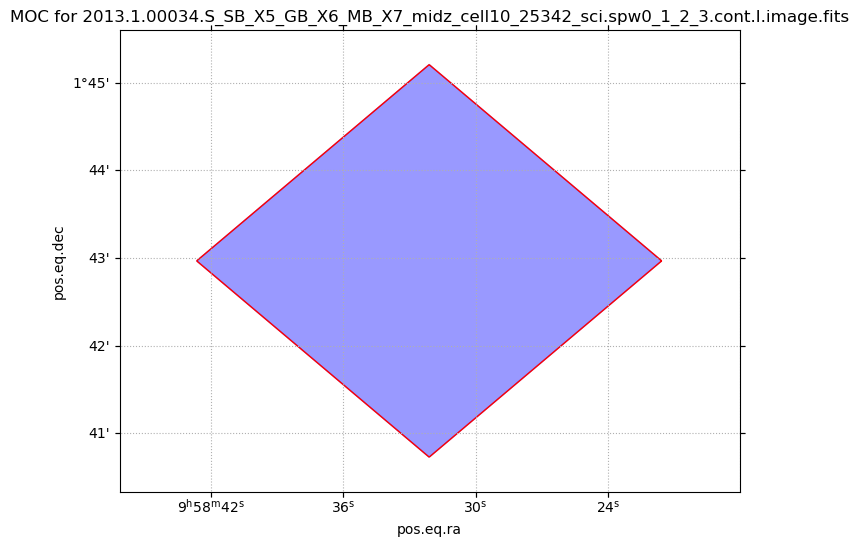

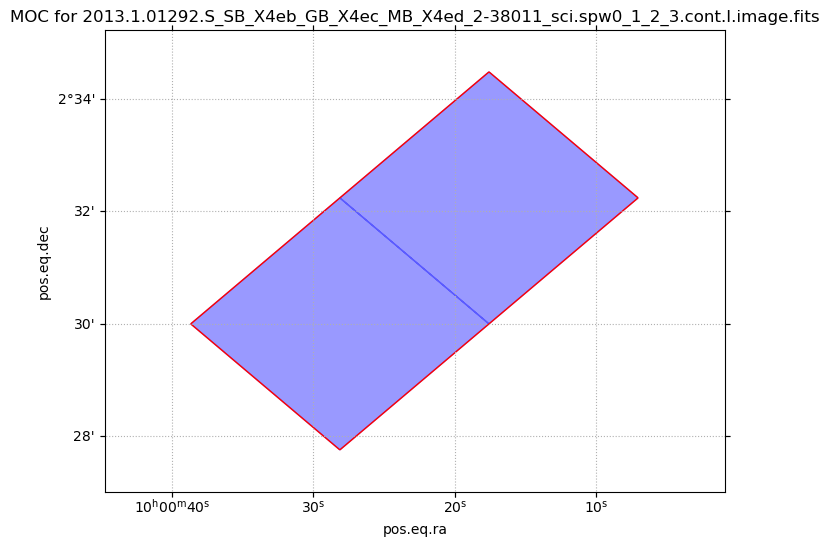

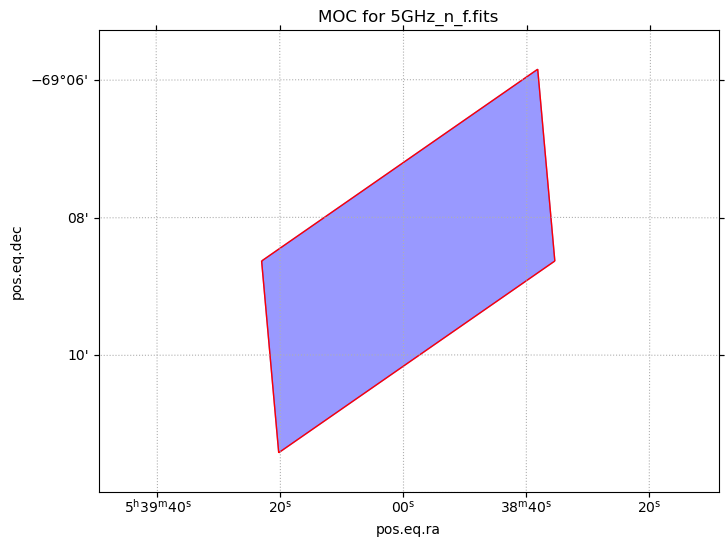

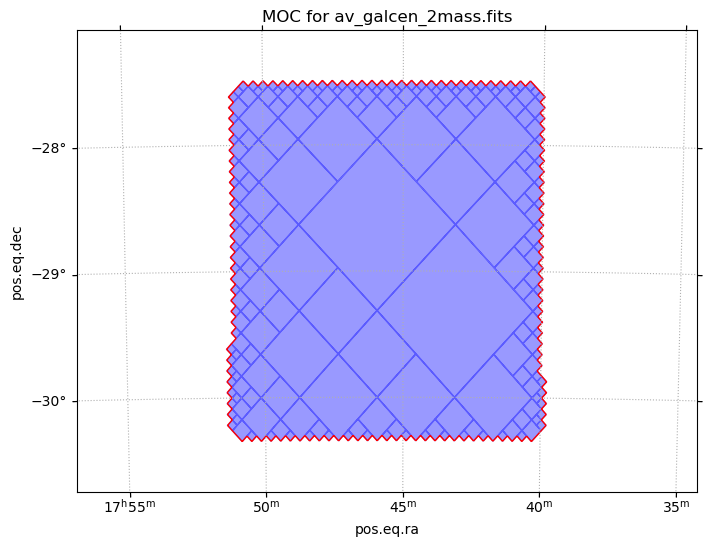

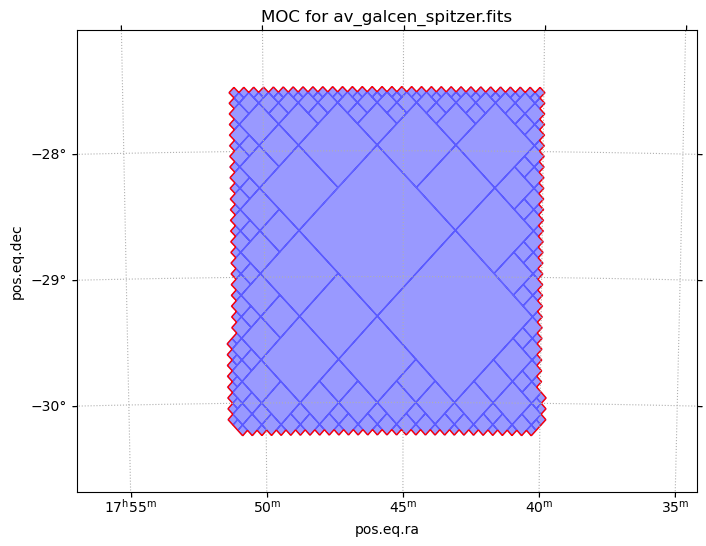

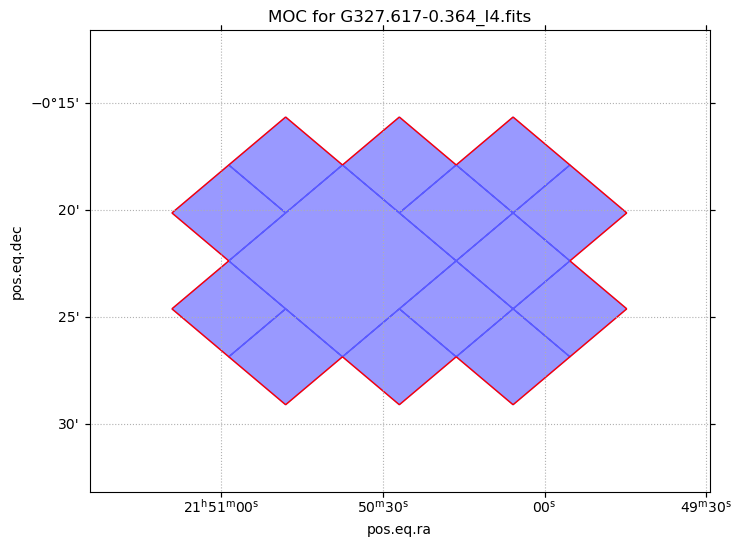

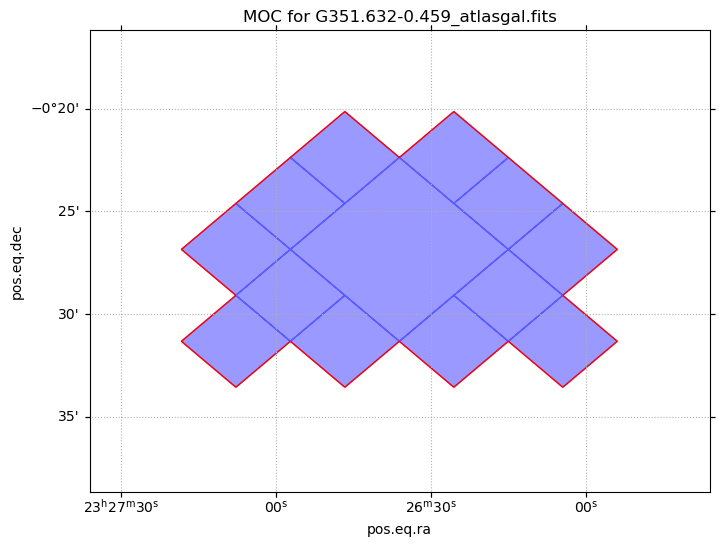

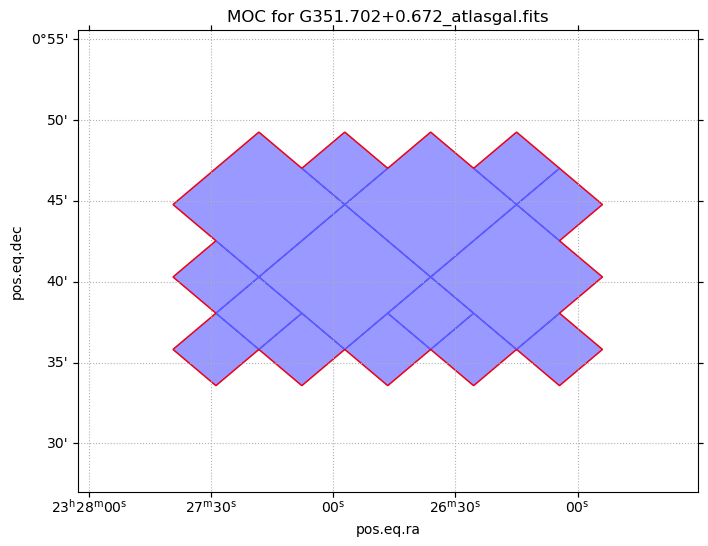

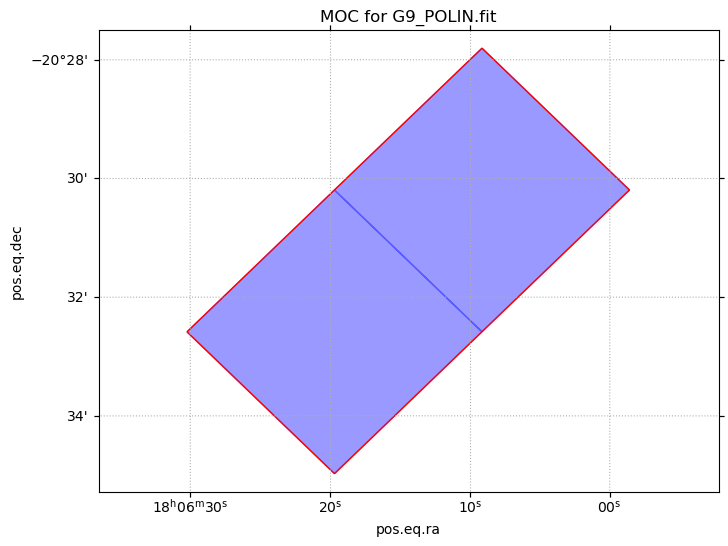

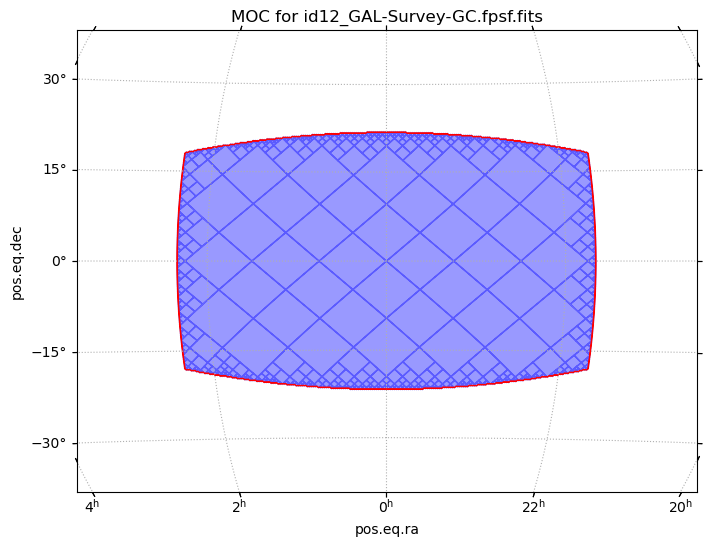

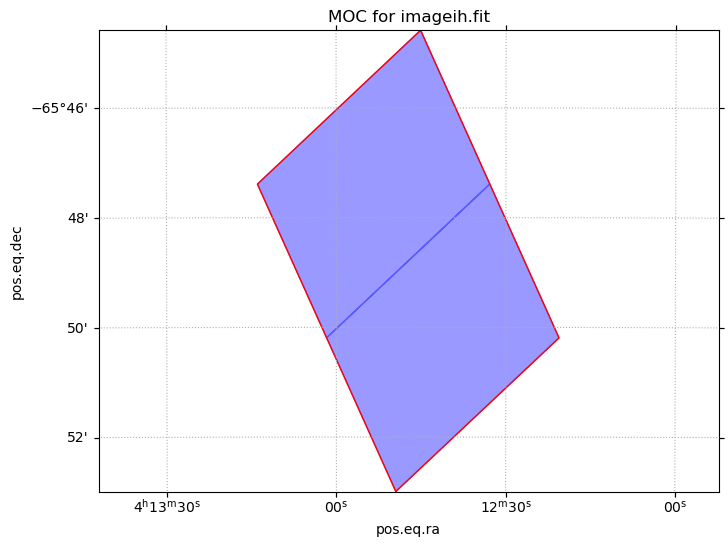

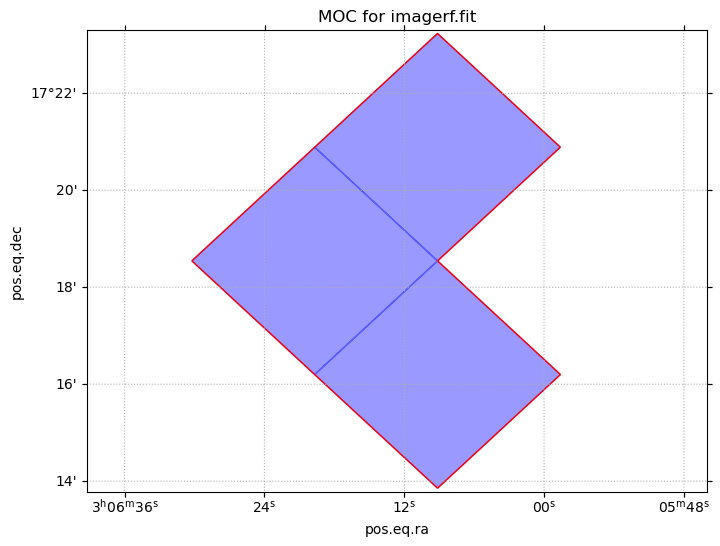

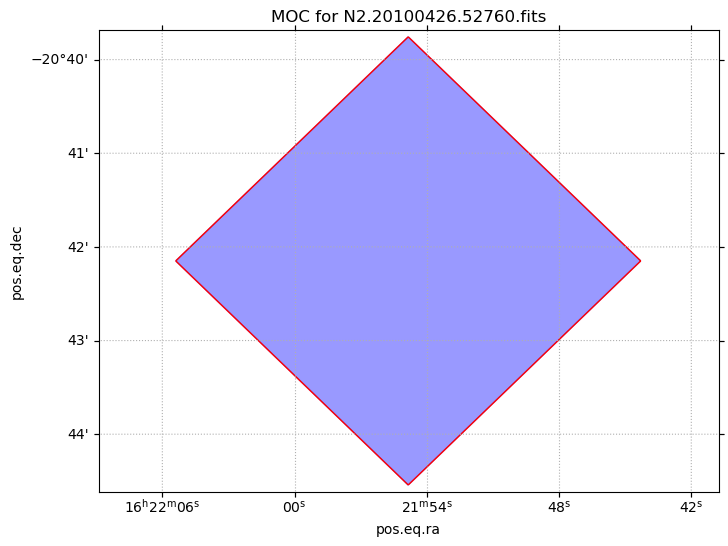

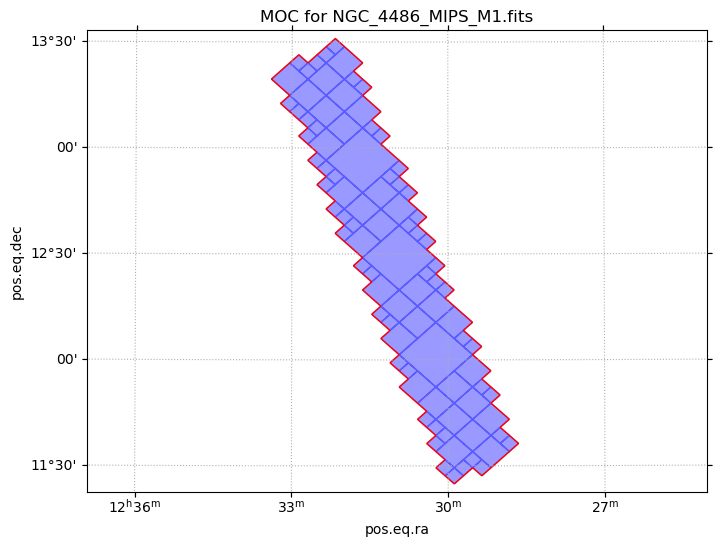

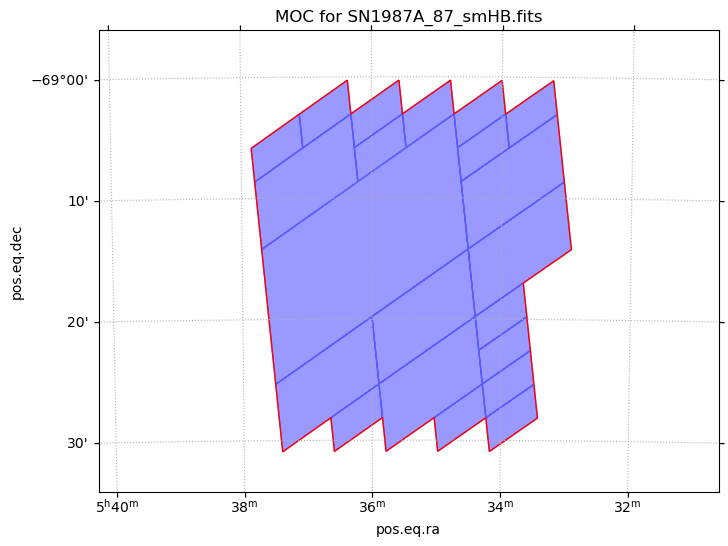

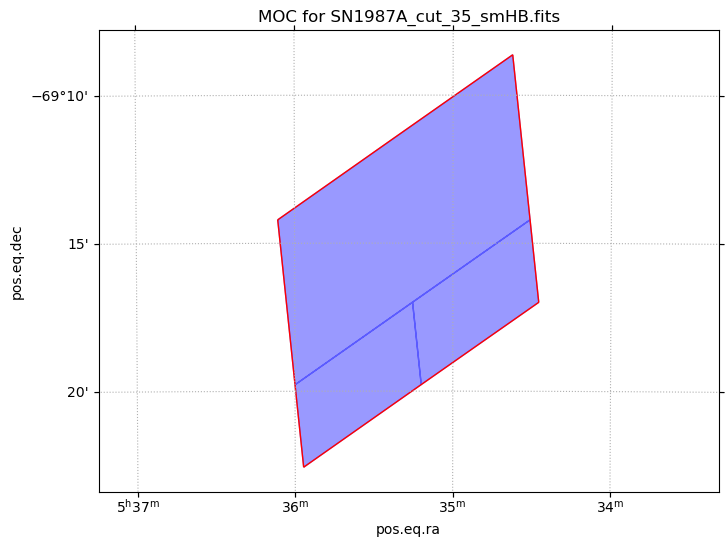

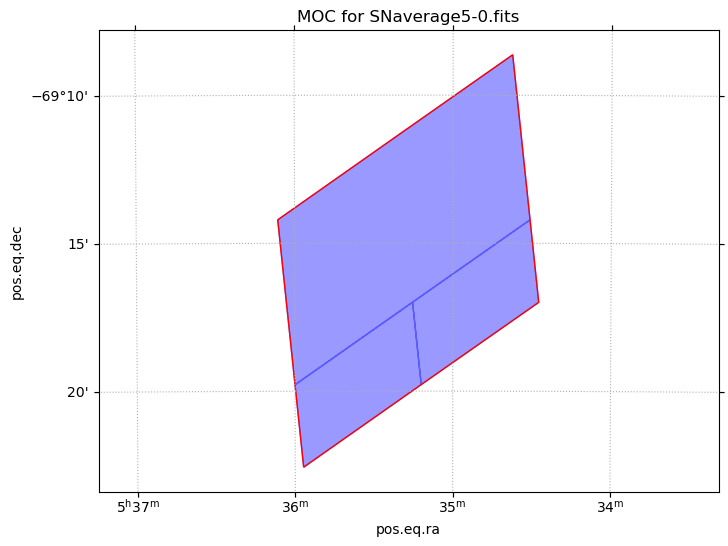

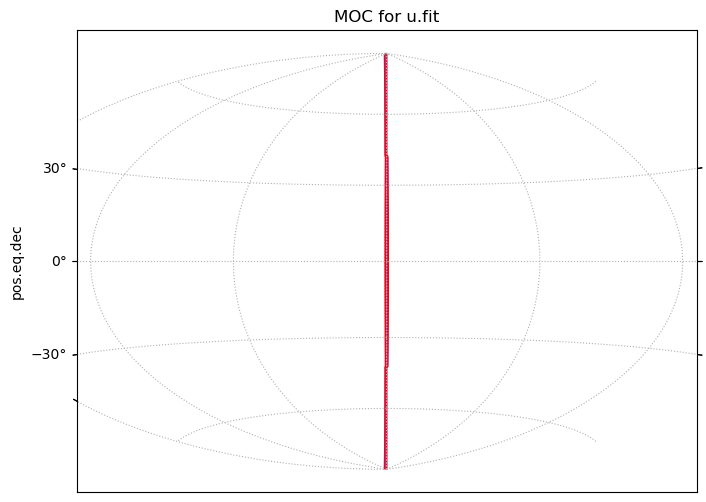

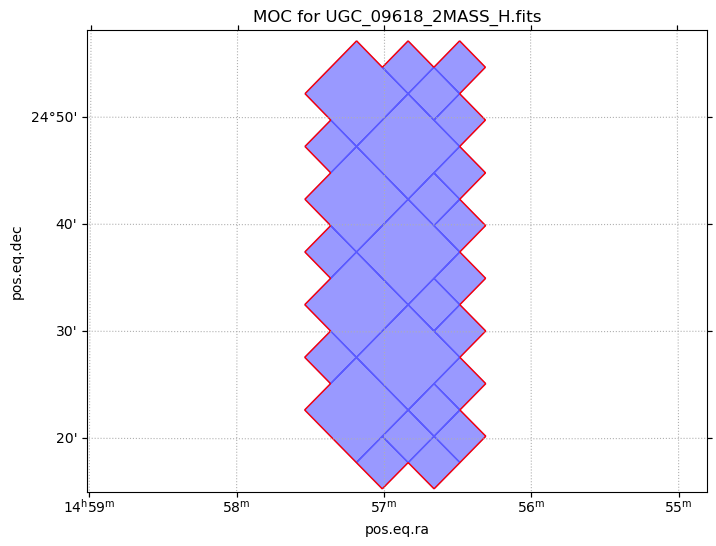

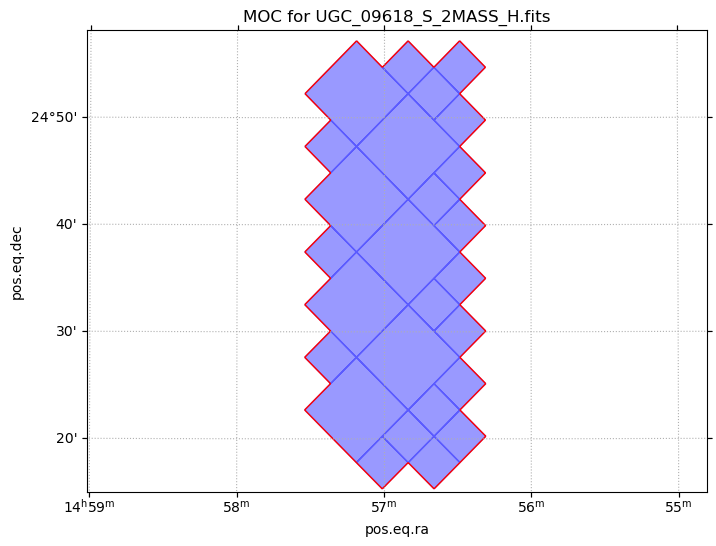

In [10]:

csv_path = r"C:\Home_items\moc_astro\metadata_set.csv"

# 1) Load MOCs + filenames from CSV
moc_data = load_mocs_and_filenames(csv_path, moc_column="MOC", filename_column="FILENAME")

# 2) Loop over each (moc_obj, fname) pair
for i, (moc_obj, fname) in enumerate(moc_data):
    if moc_obj is not None:
        plot_moc_matplotlib(moc_obj, title=f"MOC for {fname}")
    else:
        print(f"No MOC available for row {i} (filename: {fname})")


In [29]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from mocpy import MOC

def plot_moc_and_fits_no_reproject(moc_obj, fits_folder, fits_filename, title="MOC + Image"):
    """
    Overlays a FITS image under a MOC coverage using the MOC's own WCS
    (i.e., moc_obj.wcs), without reprojecting the FITS data.

    Parameters
    ----------
    moc_obj : MOC
        A MOC object from mocpy (already parsed).
    fits_folder : str
        Folder path containing your .fits/.fit files.
    fits_filename : str
        Filename matching MOC (e.g., "av_galcen_2mass.fits").
    title : str, optional
        Title for the plot.

    Notes
    -----
    - We do NOT use reproject. Instead, we rely on transform=ax.get_transform(...)
      so the FITS WCS is mapped onto the MOC's WCS axes.
    - If the FITS WCS and MOC coverage do not align (different frames or references),
      the overlay may look misaligned.
    """
    fig = plt.figure(figsize=(8, 6))

    # 1) Build a WCS from the MOC coverage
    try:
        wcs_moc = moc_obj.wcs(fig=fig)  # MOC's bounding region
    except AttributeError:
        print("Your mocpy is too old for 'moc_obj.wcs(fig=...)'. Upgrade mocpy >= 0.10.")
        return

    ax = fig.add_subplot(111, projection=wcs_moc)
    ax.grid(True, ls=":")
    ax.set_title(title)

    # 2) Load the FITS data
    fits_path = os.path.join(fits_folder, fits_filename)
    if not os.path.isfile(fits_path):
        print(f"FITS file not found: {fits_path}. Plotting only MOC.")
    else:
        try:
            with fits.open(fits_path) as hdul:
                data = hdul[0].data
                hdr = hdul[0].header

            # If data has more than 2 dims (e.g., 3D), slice down to 2D
            while data.ndim > 2:
                data = data[0]

            # Build the WCS for the FITS
            wcs_fits = WCS(hdr)

            # Plot the data with a transform to the MOC axes
            ax.imshow(
                data,
                origin='lower',
                cmap='gray',
                alpha=0.6,
                transform=ax.get_transform(wcs_fits)  # Map fits coords -> MOC coords
            )
        except Exception as e:
            print(f"Error loading/plotting {fits_filename}: {e}")

    # 3) Overlay the MOC coverage
    moc_obj.fill(ax=ax, wcs=wcs_moc, alpha=0.4, color="blue")
    moc_obj.border(ax=ax, wcs=wcs_moc, color="red")

    plt.show()


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting 2013.1.00034.S_SB_X5_GB_X6_MB_X7_midz_cell10_25342_sci.spw0_1_2_3.cont.I.image.fits: WCS has more than 2 pixel dimensions, so 'slices' should be set


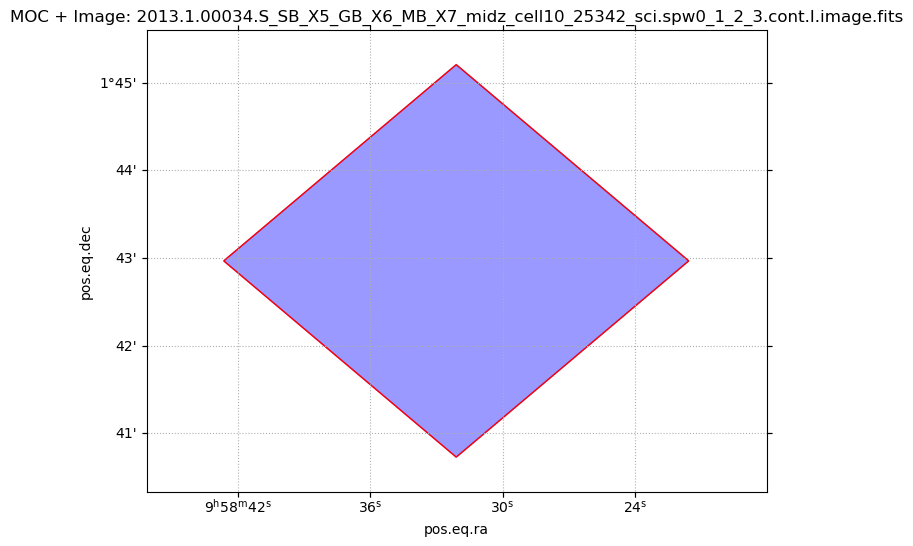

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting 2013.1.01292.S_SB_X4eb_GB_X4ec_MB_X4ed_2-38011_sci.spw0_1_2_3.cont.I.image.fits: WCS has more than 2 pixel dimensions, so 'slices' should be set


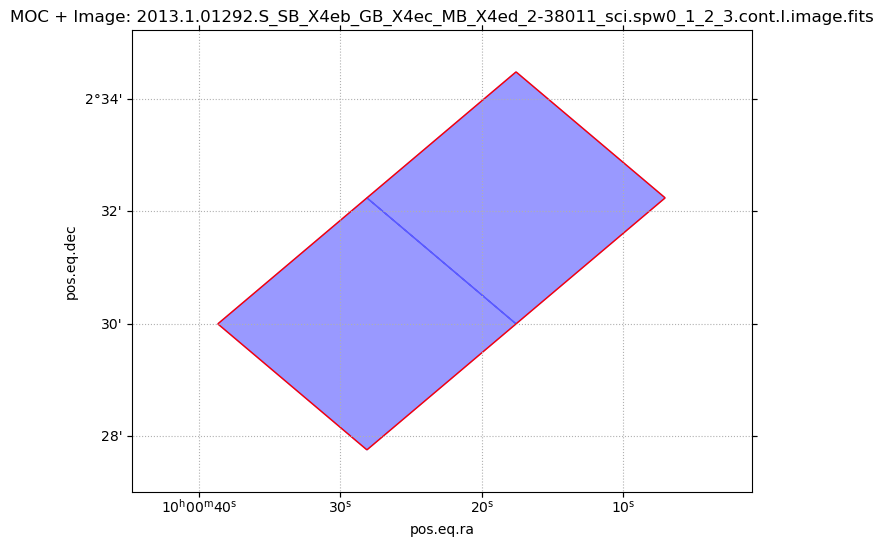

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting 5GHz_n_f.fits: WCS has more than 2 pixel dimensions, so 'slices' should be set


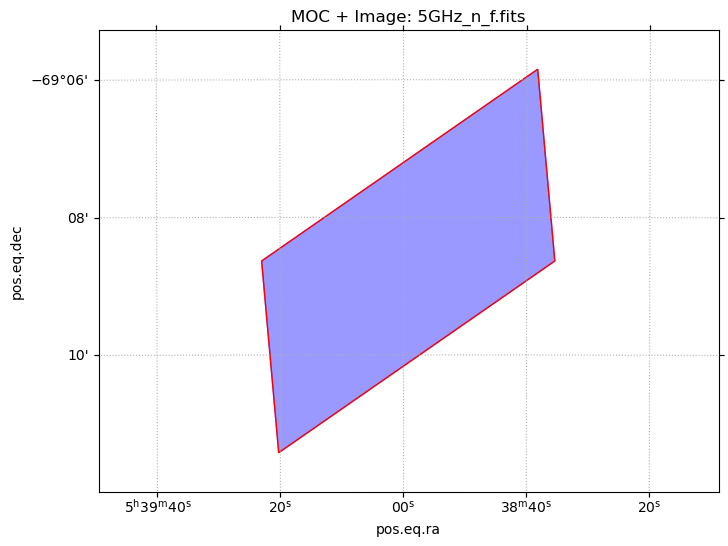

a floating-point value was expected. [astropy.wcs.wcs]


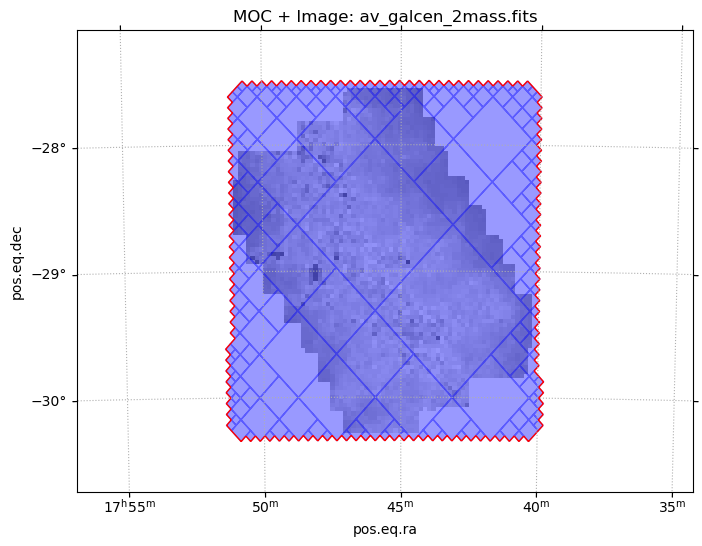

a floating-point value was expected. [astropy.wcs.wcs]


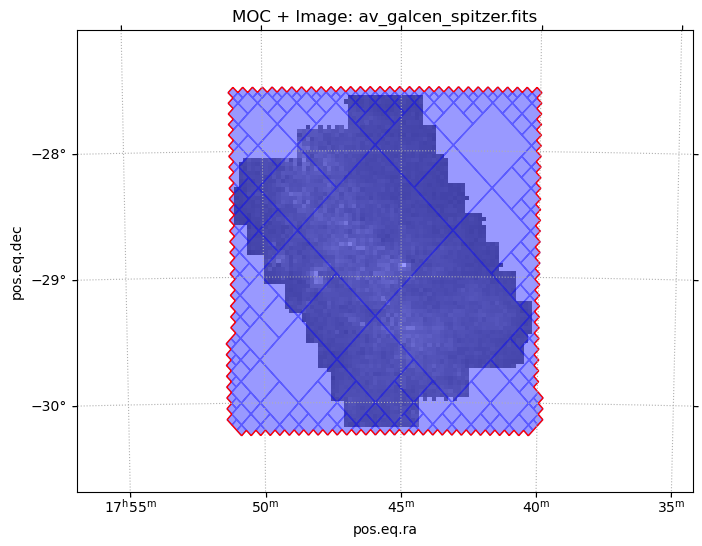

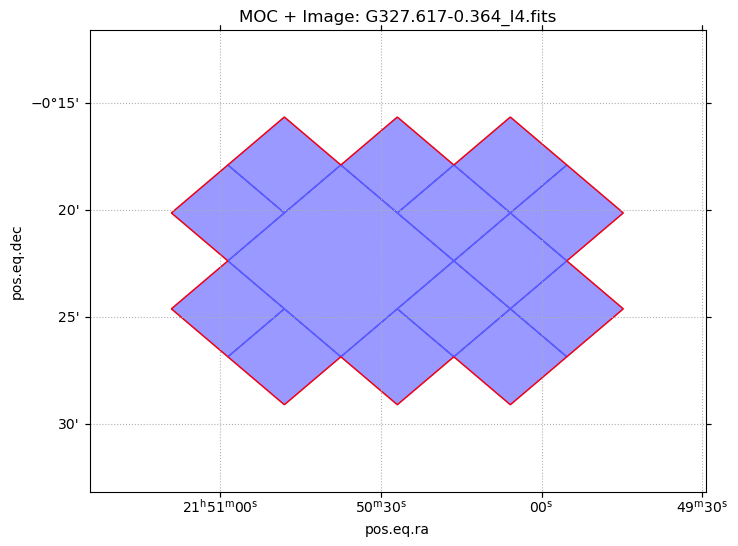

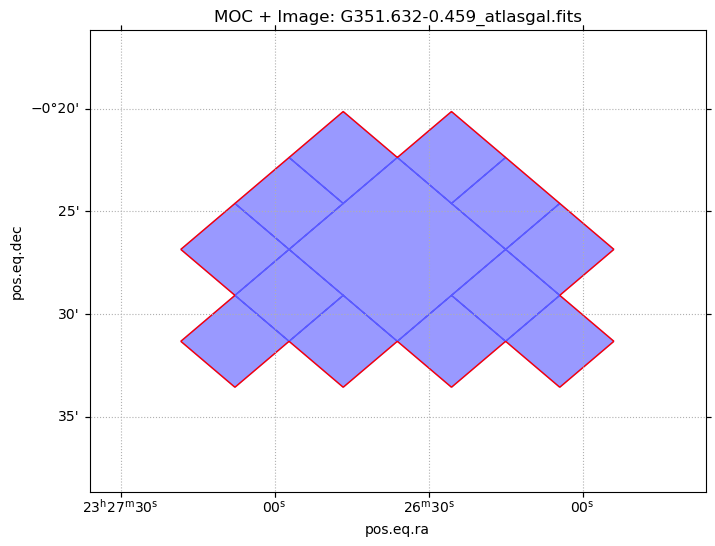

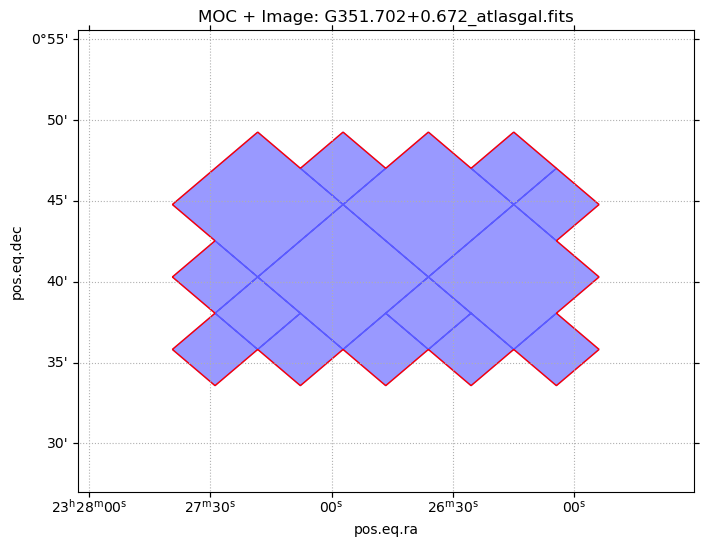

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting G9_POLIN.fit: WCS has more than 2 pixel dimensions, so 'slices' should be set


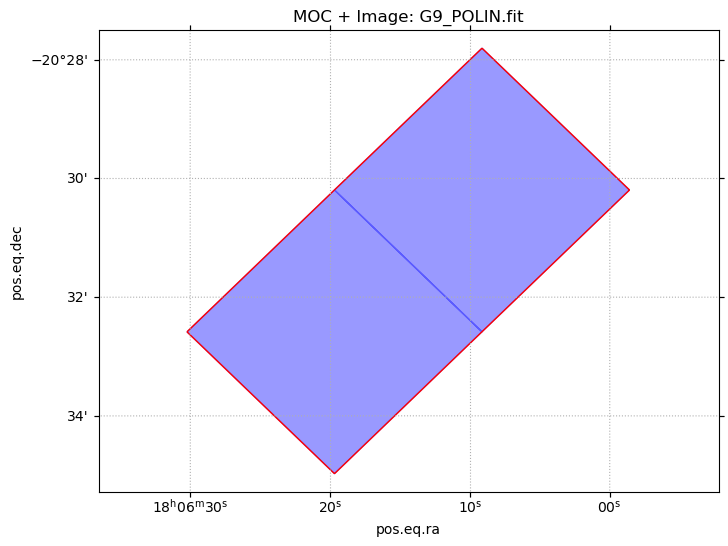

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


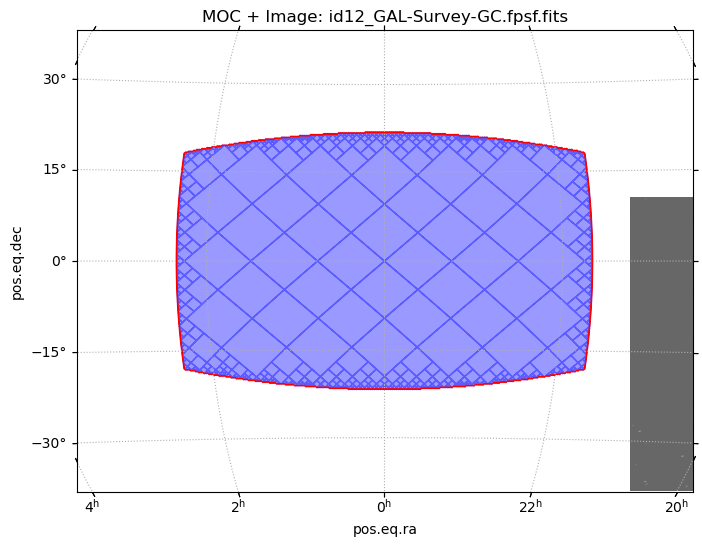

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '16/11/94' to '1994-11-16''. [astropy.wcs.wcs]


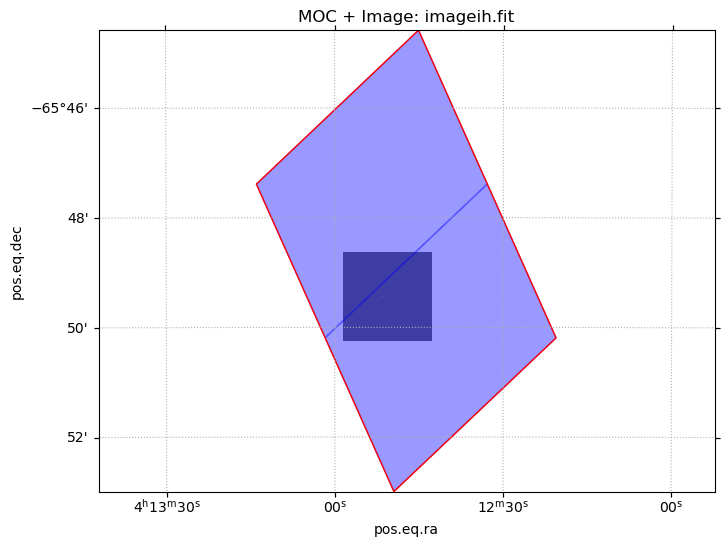

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '20/09/94' to '1994-09-20''. [astropy.wcs.wcs]


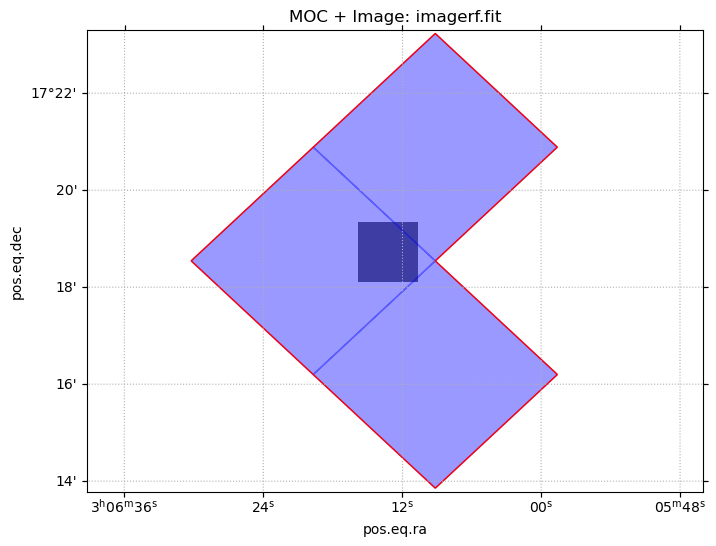

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


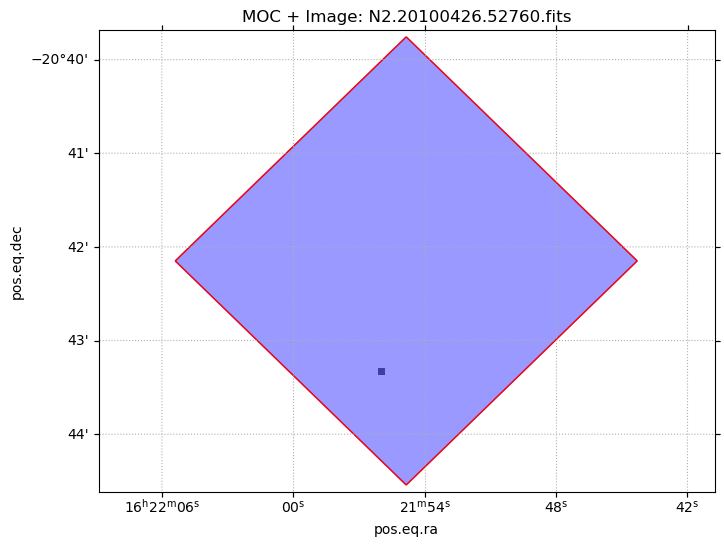

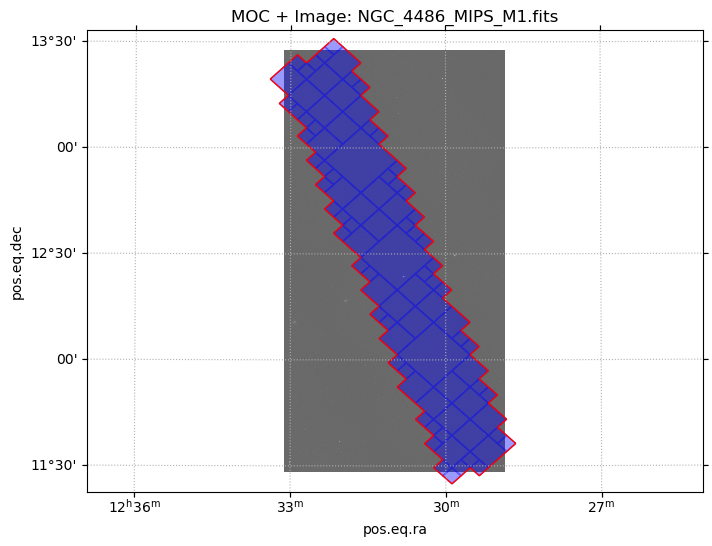

a floating-point value was expected. [astropy.wcs.wcs]


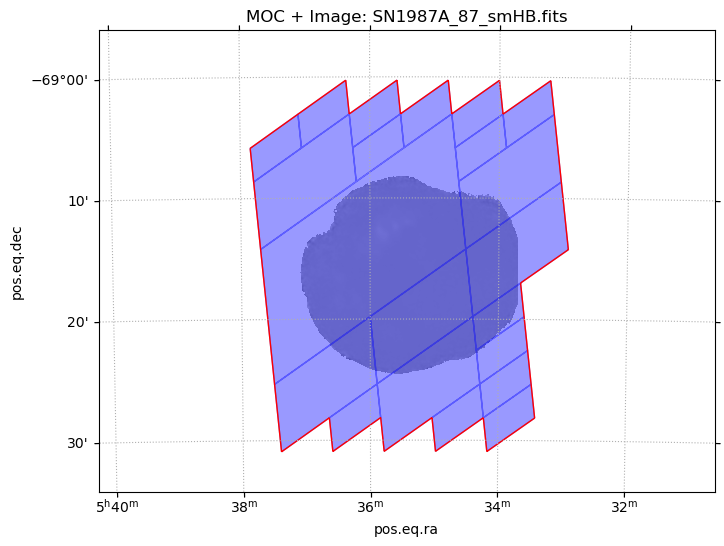

a floating-point value was expected. [astropy.wcs.wcs]


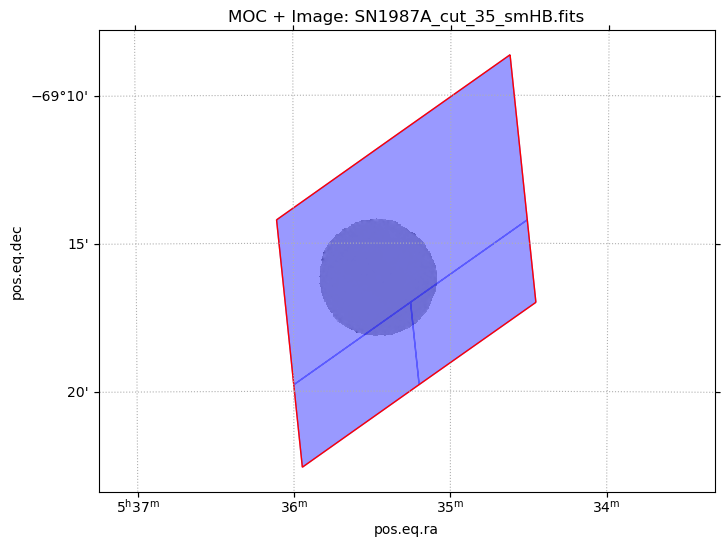

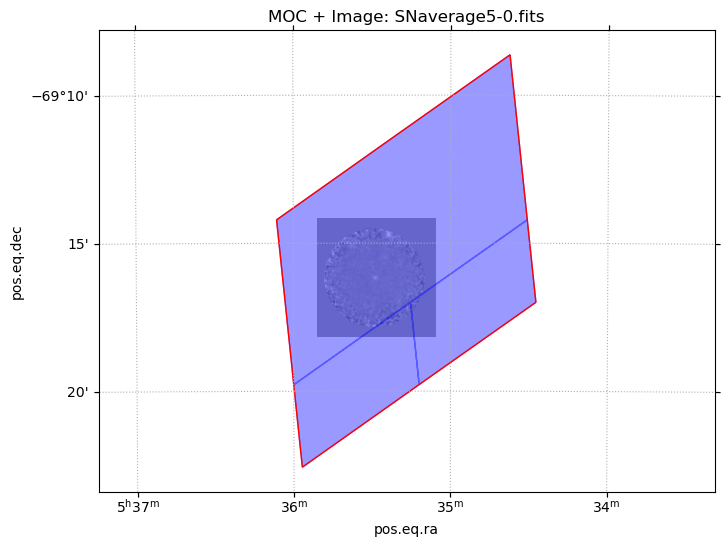

  'DEG' -> 'deg',
  'DEG' -> 'deg'. [astropy.wcs.wcs]


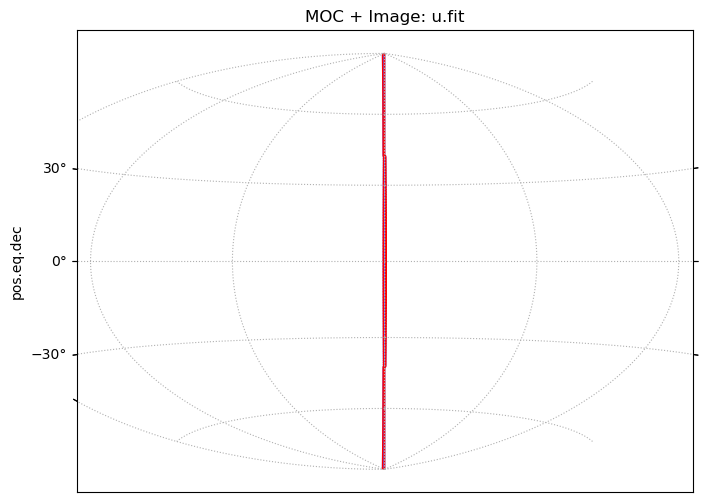

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


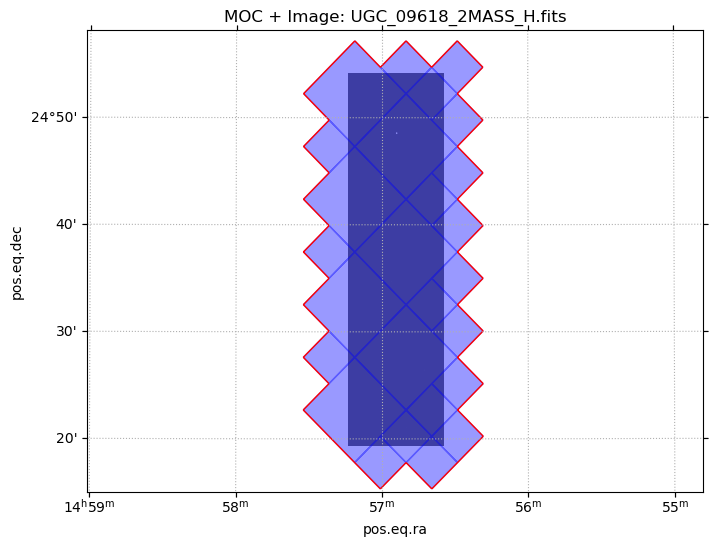

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


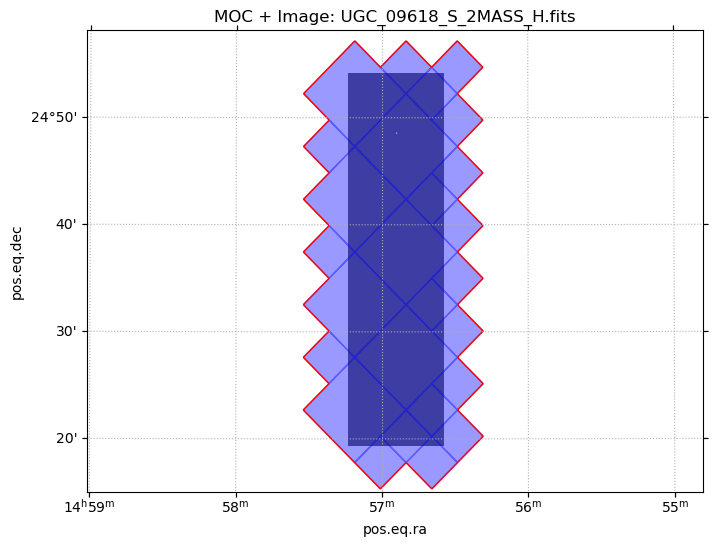

In [31]:


csv_path = r"C:\Home_items\moc_astro\metadata_set.csv"
fits_folder = r"C:\Home_items\fitscollection"

moc_data = load_mocs_and_filenames(csv_path, moc_column="MOC", filename_column="FILENAME")

for i, (moc_obj, fname) in enumerate(moc_data):
    if moc_obj is not None:
        plot_moc_and_fits_no_reproject(
            moc_obj=moc_obj,
            fits_folder=fits_folder,
            fits_filename=fname,
            title=f"MOC + Image: {fname}"
        )
    else:
        print(f"No MOC for row {i} (filename={fname})")


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting 2013.1.00034.S_SB_X5_GB_X6_MB_X7_midz_cell10_25342_sci.spw0_1_2_3.cont.I.image.fits: WCS has more than 2 pixel dimensions, so 'slices' should be set


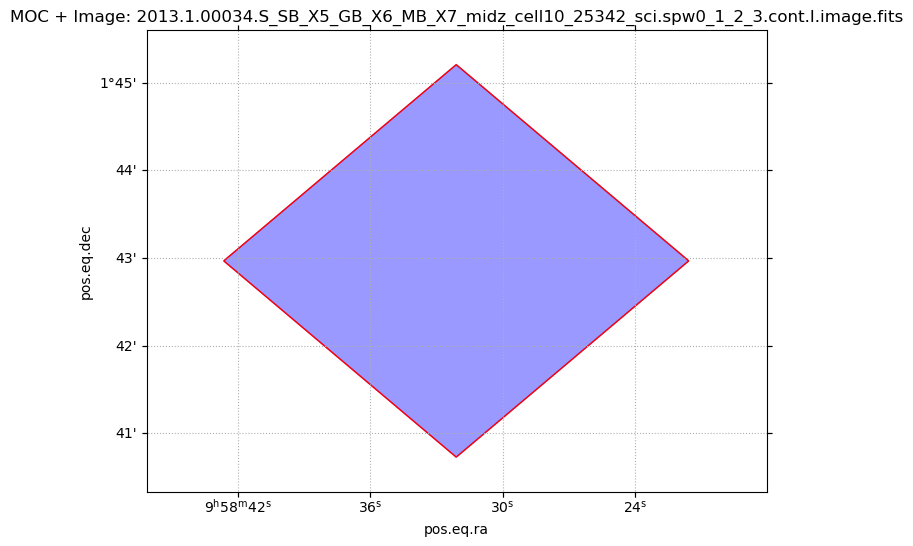

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting 2013.1.01292.S_SB_X4eb_GB_X4ec_MB_X4ed_2-38011_sci.spw0_1_2_3.cont.I.image.fits: WCS has more than 2 pixel dimensions, so 'slices' should be set


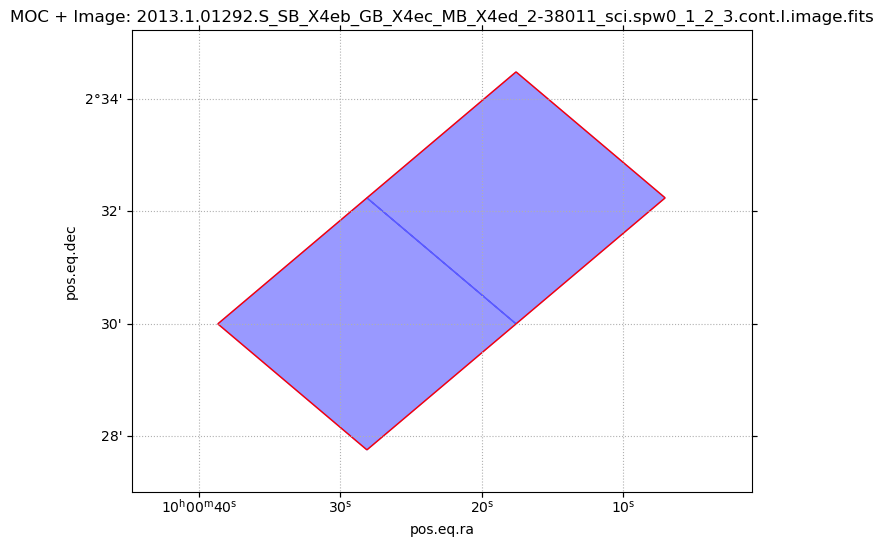

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting 5GHz_n_f.fits: WCS has more than 2 pixel dimensions, so 'slices' should be set


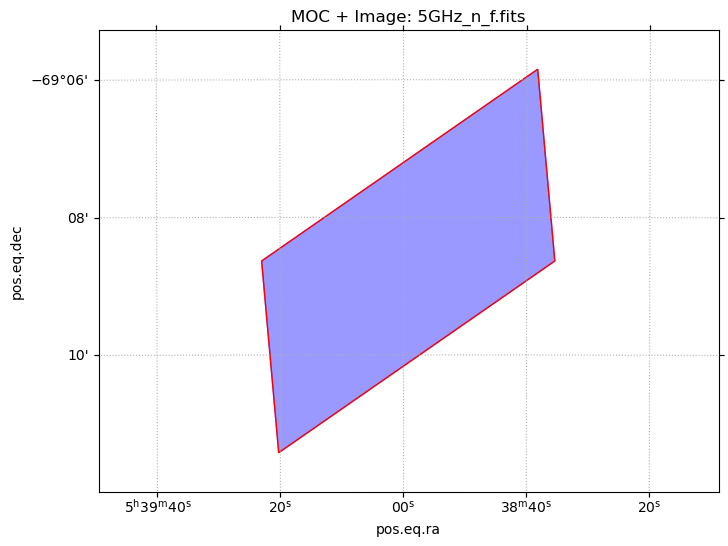

a floating-point value was expected. [astropy.wcs.wcs]


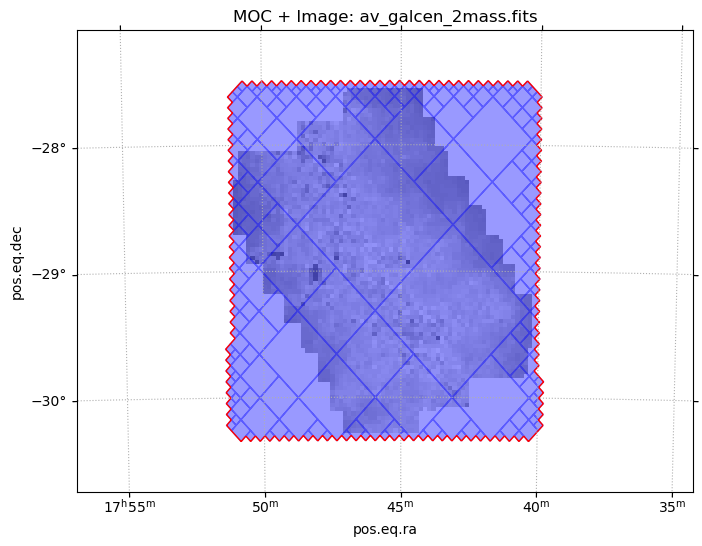

a floating-point value was expected. [astropy.wcs.wcs]


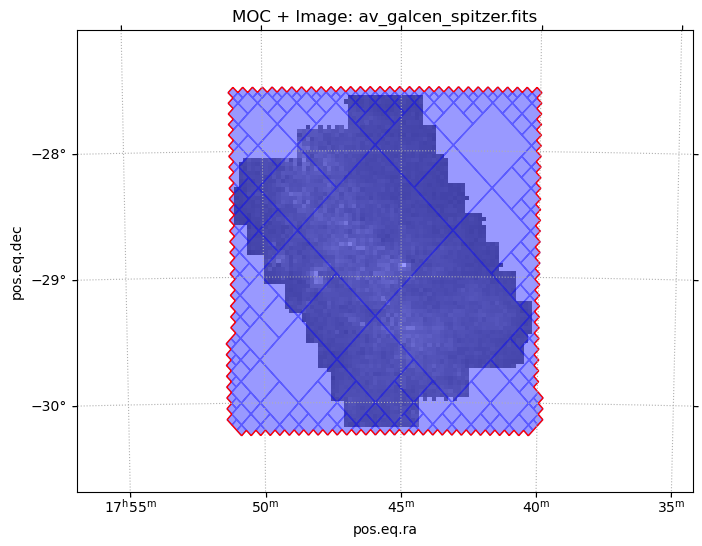

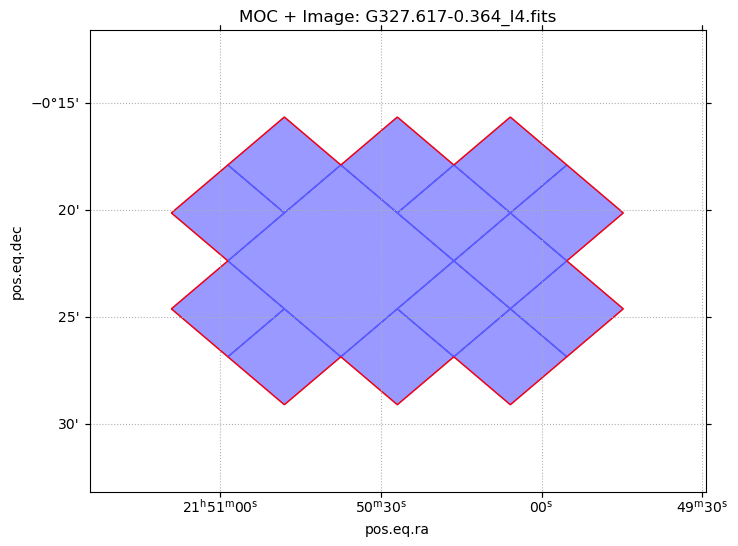

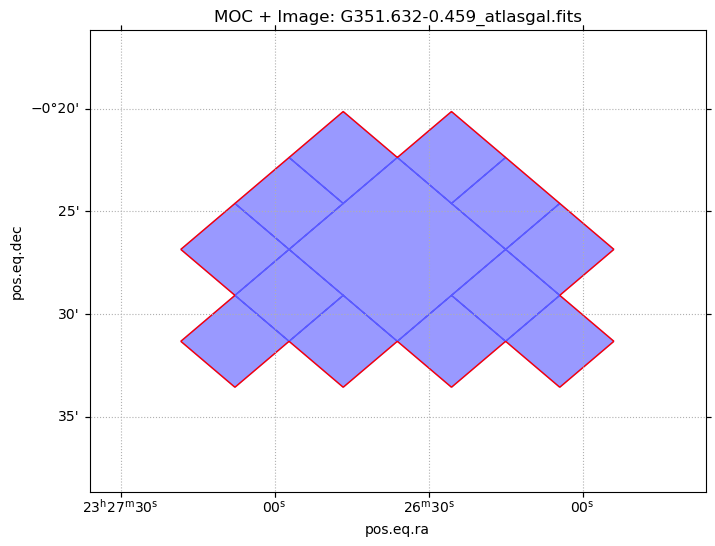

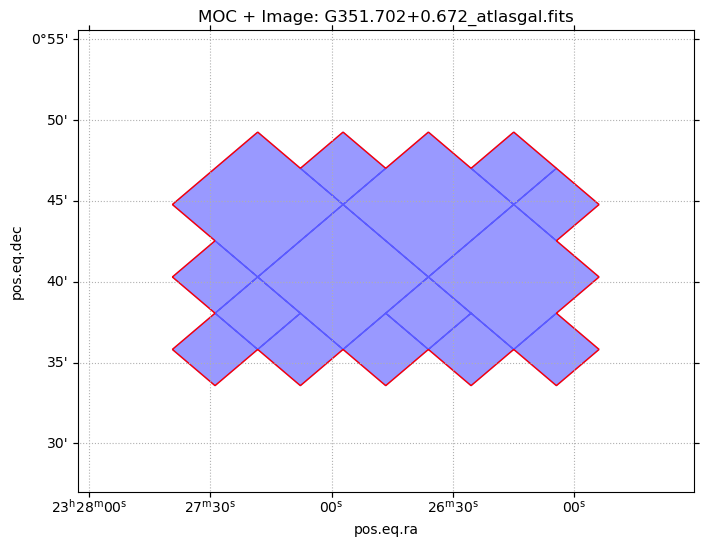

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Error loading/plotting G9_POLIN.fit: WCS has more than 2 pixel dimensions, so 'slices' should be set


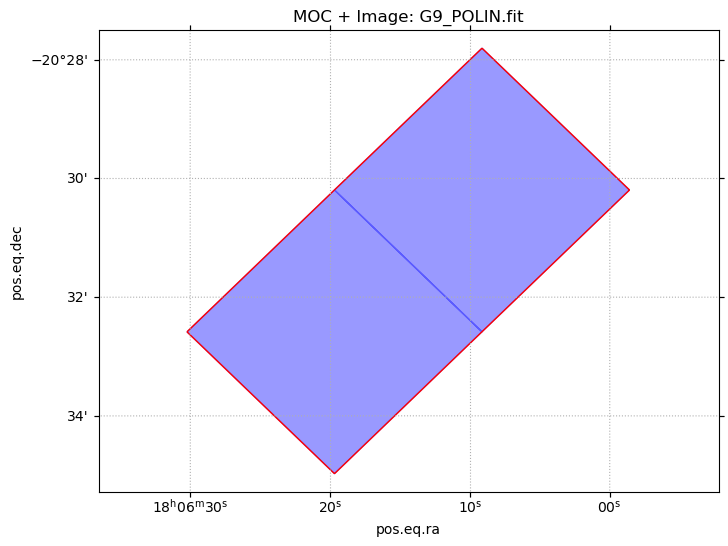

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


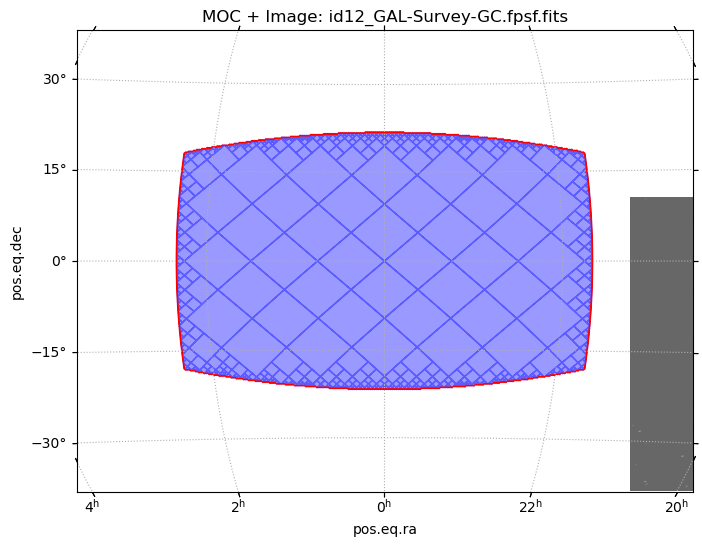

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '16/11/94' to '1994-11-16''. [astropy.wcs.wcs]


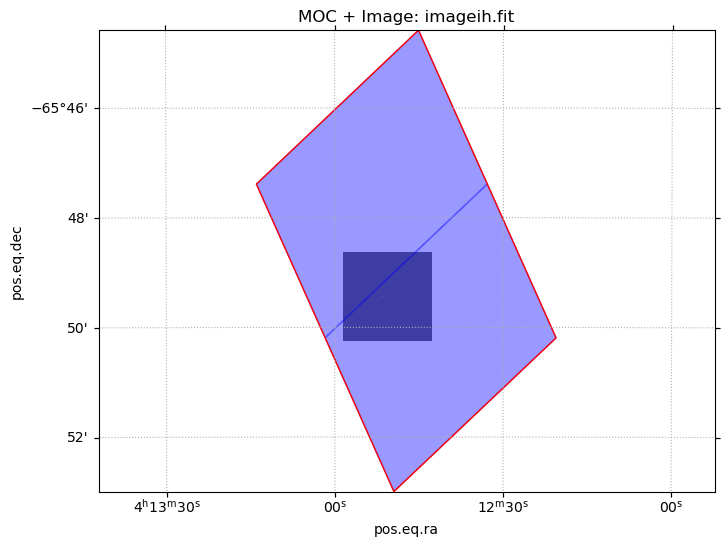

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '20/09/94' to '1994-09-20''. [astropy.wcs.wcs]


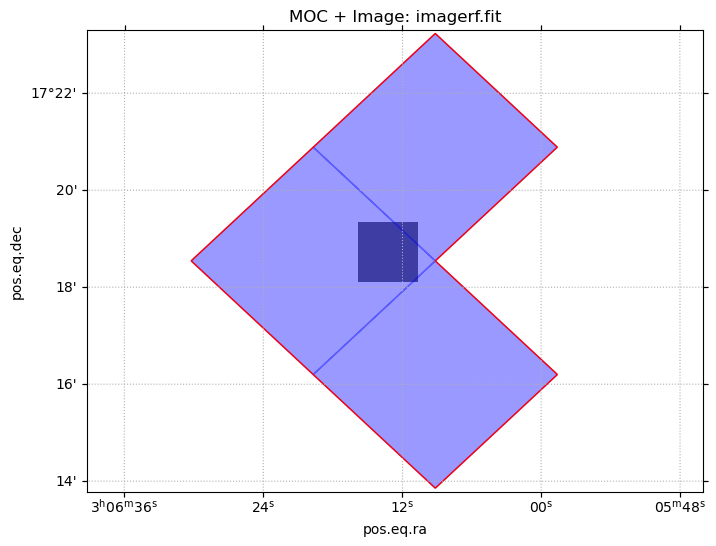

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


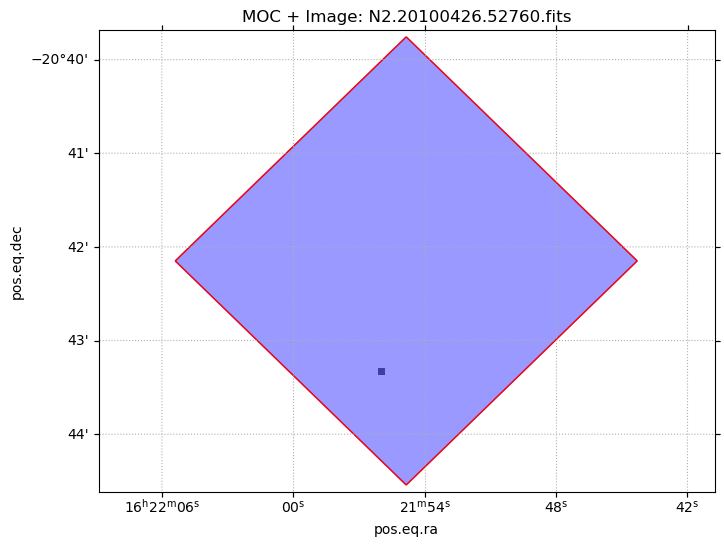

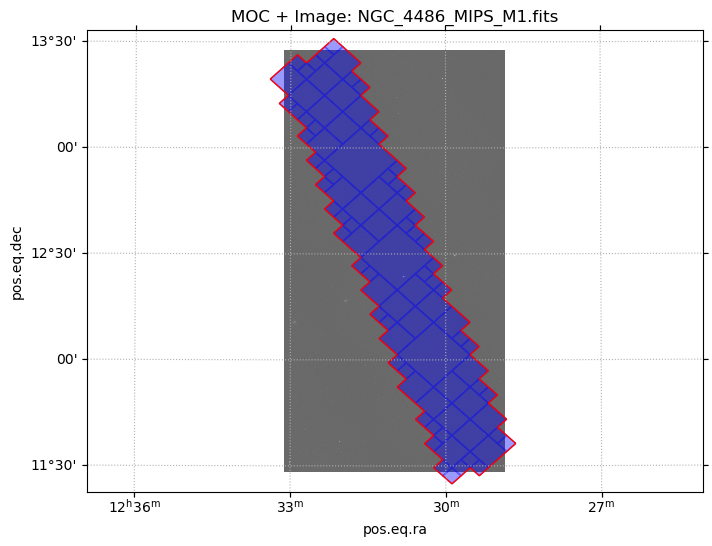

a floating-point value was expected. [astropy.wcs.wcs]


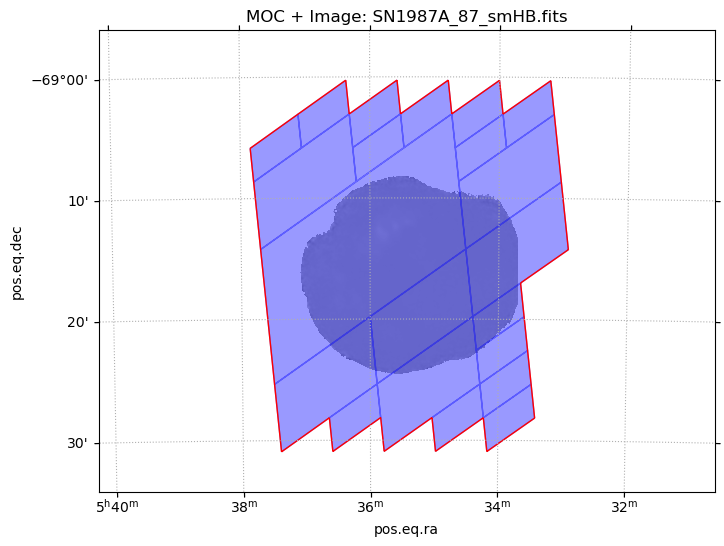

a floating-point value was expected. [astropy.wcs.wcs]


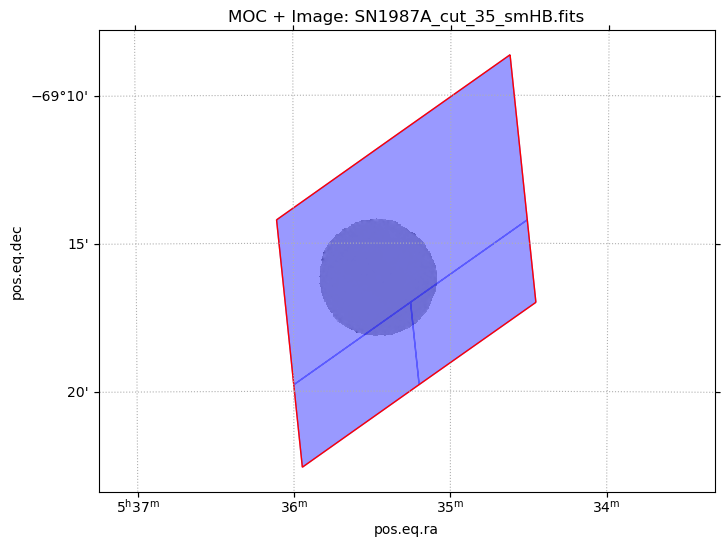

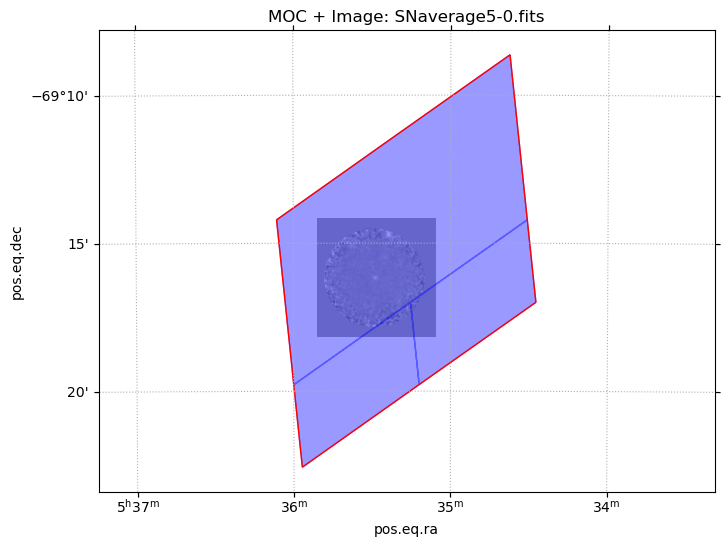

  'DEG' -> 'deg',
  'DEG' -> 'deg'. [astropy.wcs.wcs]


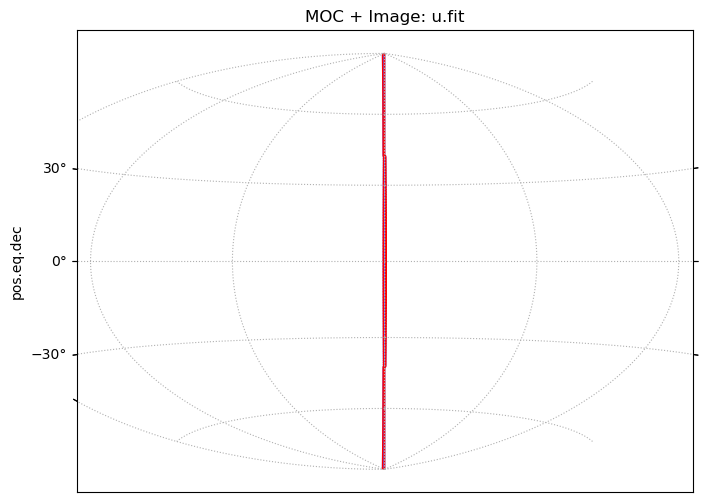

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


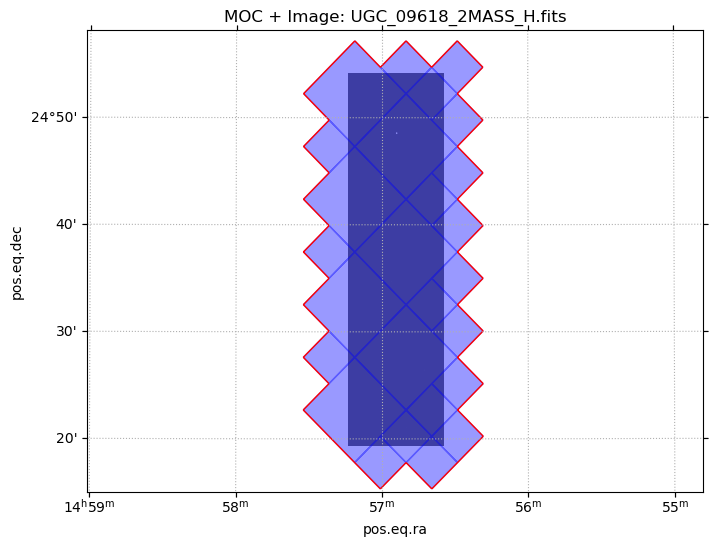

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


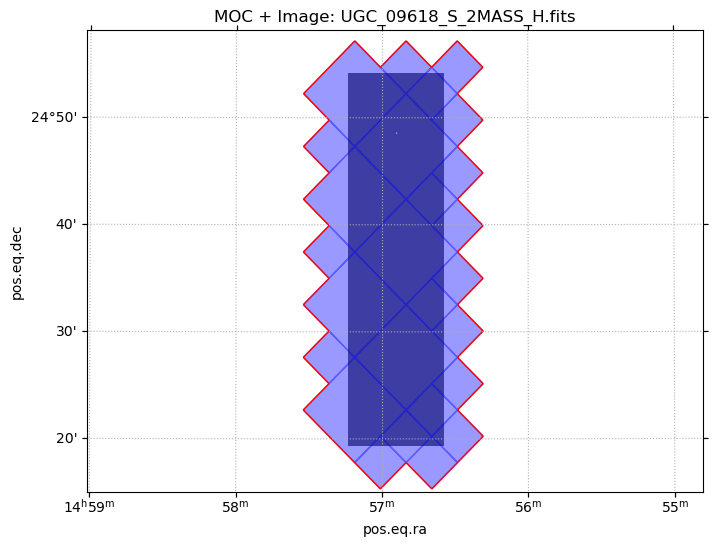

In [32]:
import csv
import os
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from mocpy import MOC

##############################################################################
# Step 1: Load MOCs + Filenames from CSV
##############################################################################

def load_mocs_and_filenames(csv_path, moc_column="MOC", filename_column="FILENAME"):
    """
    Reads MOC text strings and filenames from a CSV, parses them into MOC objects,
    and returns a list of (moc_obj, filename).

    Parameters
    ----------
    csv_path : str
        Path to the CSV file created by 'create_fits_csv'.
    moc_column : str, optional
        Name of the column containing the MOC strings (default 'MOC').
    filename_column : str, optional
        Name of the column containing the filename (default 'FILENAME').

    Returns
    -------
    list of (MOC or None, str)
        Each entry is a tuple (moc_obj, filename). If the MOC cannot be parsed,
        moc_obj will be None, but filename will still be the CSV's filename column.
    """
    data = []
    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            moc_str = row.get(moc_column, "")
            fname = row.get(filename_column, "Unknown")

            if moc_str and moc_str.strip() != "None":
                try:
                    moc_obj = MOC.from_string(moc_str)
                    data.append((moc_obj, fname))
                except Exception as e:
                    print(f"Could not parse MOC string '{moc_str}': {e}")
                    data.append((None, fname))
            else:
                # No valid MOC in this row
                data.append((None, fname))
    return data

##############################################################################
# Step 2: Plot MOC + (Optional) FITS Overlay (No Reproject)
##############################################################################

def plot_moc_and_fits_no_reproject(moc_obj, fits_folder, fits_filename, title="MOC + Image"):
    """
    Overlays a FITS image under a MOC coverage using the MOC's own WCS
    (i.e., moc_obj.wcs), without reprojecting the FITS data.

    Parameters
    ----------
    moc_obj : MOC
        A MOC object from mocpy (already parsed).
    fits_folder : str
        Folder path containing your .fits/.fit files.
    fits_filename : str
        Filename matching MOC (e.g., "av_galcen_2mass.fits").
    title : str, optional
        Title for the plot.

    Notes
    -----
    - We do NOT use reproject. Instead, we rely on transform=ax.get_transform(...)
      so the FITS WCS is mapped onto the MOC's WCS axes.
    - If the FITS WCS and MOC coverage do not align (different frames or references),
      the overlay may look misaligned or might not appear at all.
    """
    fig = plt.figure(figsize=(8, 6))

    # 1) Build a WCS from the MOC coverage
    try:
        wcs_moc = moc_obj.wcs(fig=fig)  # MOC's bounding region
    except AttributeError:
        print("Your mocpy version is too old for 'moc_obj.wcs(fig=...)'. Upgrade mocpy >= 0.10.")
        return

    ax = fig.add_subplot(111, projection=wcs_moc)
    ax.grid(True, ls=":")
    ax.set_title(title)

    # 2) Load the FITS data (if present)
    fits_path = os.path.join(fits_folder, fits_filename)
    if not os.path.isfile(fits_path):
        print(f"FITS file not found: {fits_path}. Plotting only MOC.")
    else:
        try:
            with fits.open(fits_path) as hdul:
                data = hdul[0].data
                hdr = hdul[0].header

            # If data has more than 2 dims (e.g., 3D), slice down to 2D
            while data.ndim > 2:
                data = data[0]

            # Build the WCS for the FITS
            wcs_fits = WCS(hdr)

            # Plot the data with a transform to the MOC axes
            ax.imshow(
                data,
                origin='lower',
                cmap='gray',
                alpha=0.6,
                transform=ax.get_transform(wcs_fits)  # Map FITS coords to MOC coords
            )
        except Exception as e:
            print(f"Error loading/plotting {fits_filename}: {e}")

    # 3) Overlay the MOC coverage
    moc_obj.fill(ax=ax, wcs=wcs_moc, alpha=0.4, color="blue")
    moc_obj.border(ax=ax, wcs=wcs_moc, color="red")

    plt.show()

##############################################################################
# Example Usage in Jupyter Notebook (assuming this file is saved as fits_moc_plotter.py)
##############################################################################

if __name__ == "__main__":
    # Example usage:
    csv_path = r"C:\Home_items\moc_astro\metadata_set.csv"
    fits_folder = r"C:\Home_items\fitscollection"

    # Load MOCs + Filenames
    moc_data = load_mocs_and_filenames(csv_path, moc_column="MOC", filename_column="FILENAME")

    # Loop over each (moc_obj, fname) pair and plot
    for i, (moc_obj, fname) in enumerate(moc_data):
        if moc_obj is None:
            print(f"No MOC for row {i}, filename={fname}")
        else:
            plot_moc_and_fits_no_reproject(
                moc_obj=moc_obj,
                fits_folder=fits_folder,
                fits_filename=fname,
                title=f"MOC + Image: {fname}"
            )


#### This is the image

In [25]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import numpy as np

def plot_fits_images(folder_path):
    """
    Loop over all .fits files in 'folder_path', open each one, and display
    the 2D image in a Matplotlib window with celestial coordinates (if available).

    Parameters
    ----------
    folder_path : str
        Path to the folder containing FITS files.

    Notes
    -----
    - If a FITS file has more than 2 dimensions (e.g., 3D with frequency),
      we take a single 2D slice [0, :, :] to plot.
    - Uses ZScaleInterval for auto brightness/contrast.
    - If WCS is invalid, we fall back to a simple imshow without WCS axes.
    """

    # List all .fits or .fit files in the folder
    fits_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".fit", ".fits"))
    ]

    if not fits_files:
        print(f"No .fit/.fits files found in {folder_path}.")
        return

    for f in fits_files:
        fits_path = os.path.join(folder_path, f)
        try:
            with fits.open(fits_path) as hdul:
                data = hdul[0].data
                header = hdul[0].header

                # If data has more than 2 dims (e.g., 3D or 4D), take a slice
                while data.ndim > 2:
                    data = data[0]

                # Attempt to build WCS for the header
                try:
                    wcs = WCS(header)
                    # Check if we actually have 2D WCS:
                    if wcs.naxis == 2:
                        # Use a WCS Axes
                        fig = plt.figure(figsize=(6, 5))
                        ax = fig.add_subplot(111, projection=wcs)

                        # Auto-scale brightness/contrast
                        interval = ZScaleInterval()
                        vmin, vmax = interval.get_limits(data)

                        im = ax.imshow(
                            data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray'
                        )
                        ax.set_xlabel('RA')
                        ax.set_ylabel('Dec')
                        ax.set_title(f)
                    else:
                        # Fallback: no valid 2D WCS, normal imshow
                        fig, ax = plt.subplots(figsize=(6, 5))
                        interval = ZScaleInterval()
                        vmin, vmax = interval.get_limits(data)
                        im = ax.imshow(
                            data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray'
                        )
                        ax.set_title(f)

                except Exception:
                    # If WCS fails, do a simple imshow
                    fig, ax = plt.subplots(figsize=(6, 5))
                    interval = ZScaleInterval()
                    vmin, vmax = interval.get_limits(data)
                    im = ax.imshow(
                        data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray'
                    )
                    ax.set_title(f)

                # Optional colorbar
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                plt.show()

        except Exception as exc:
            print(f"Error reading {f}: {exc}")


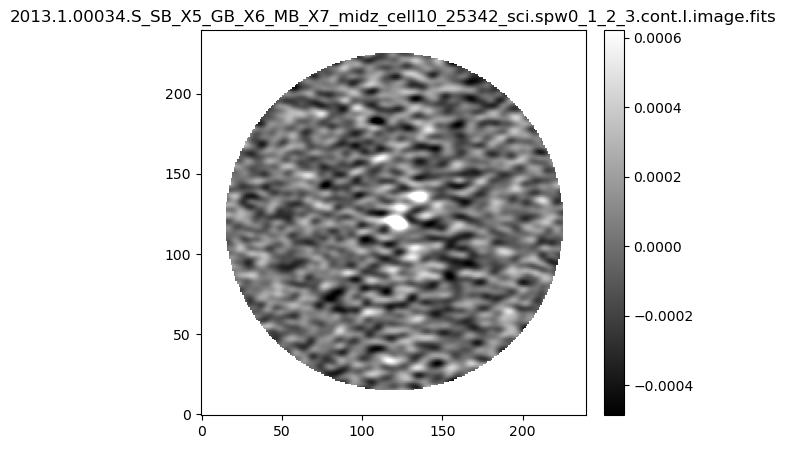

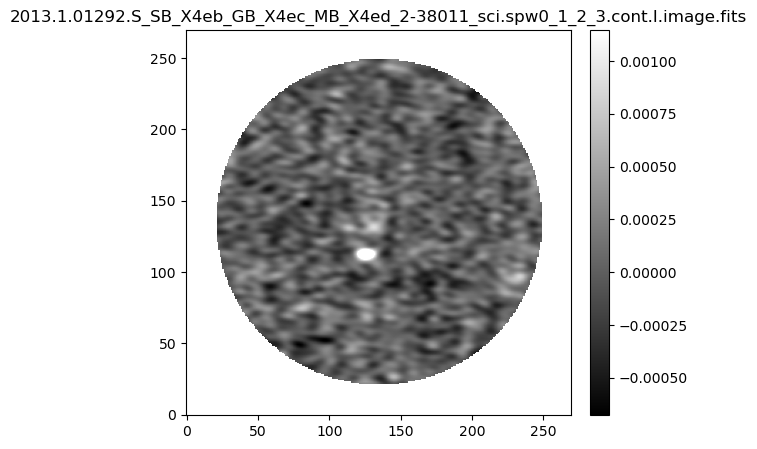

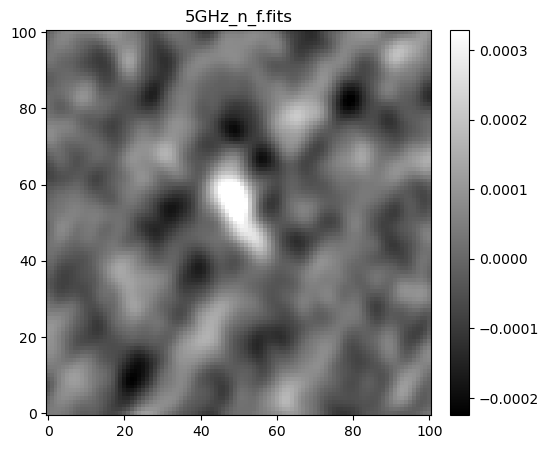

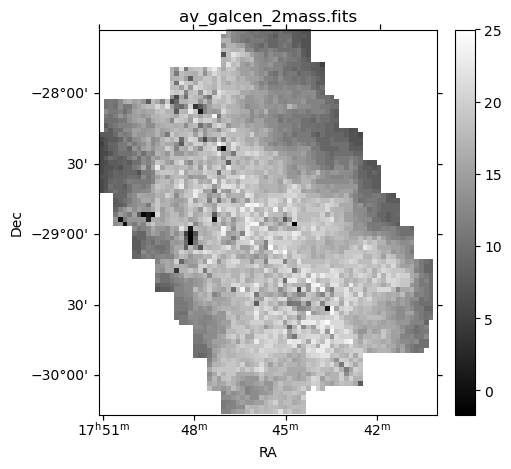

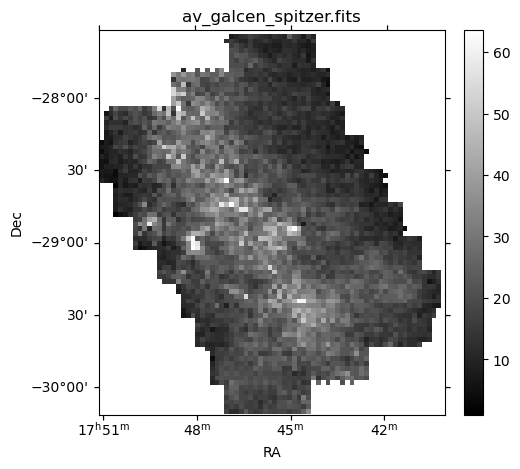

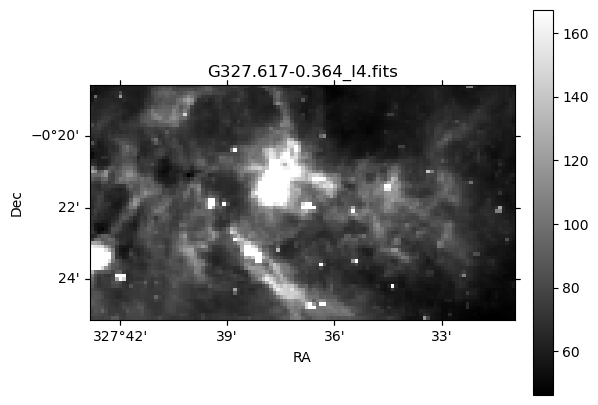

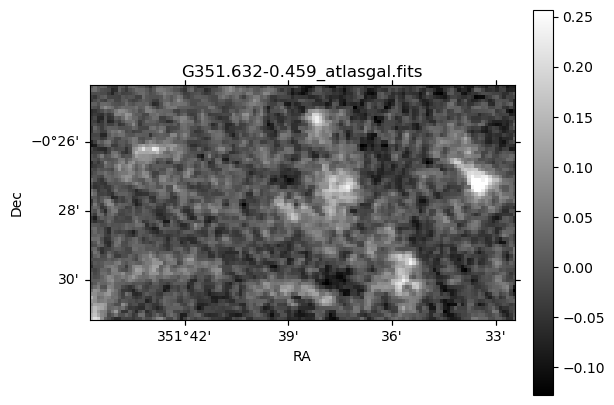

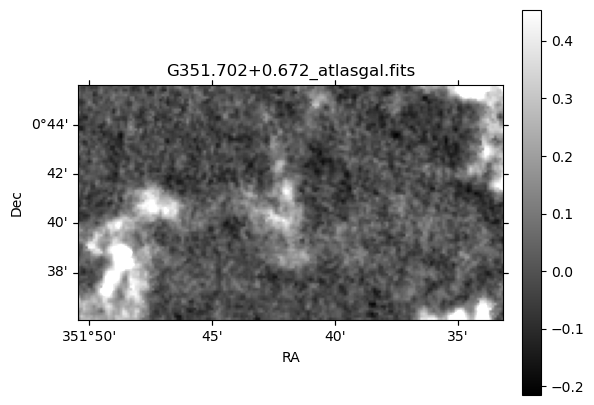

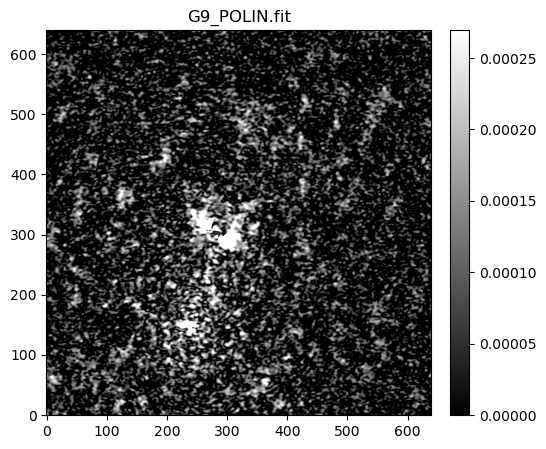

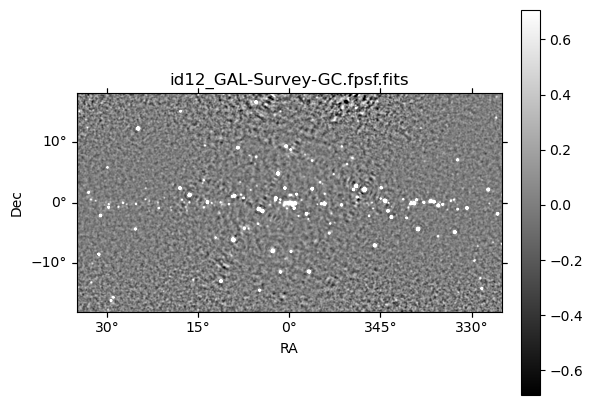

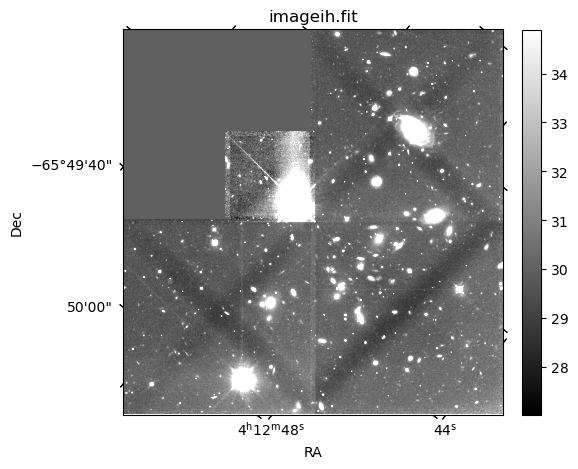

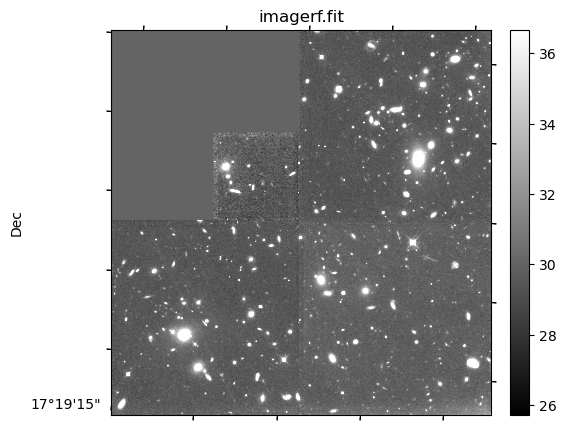

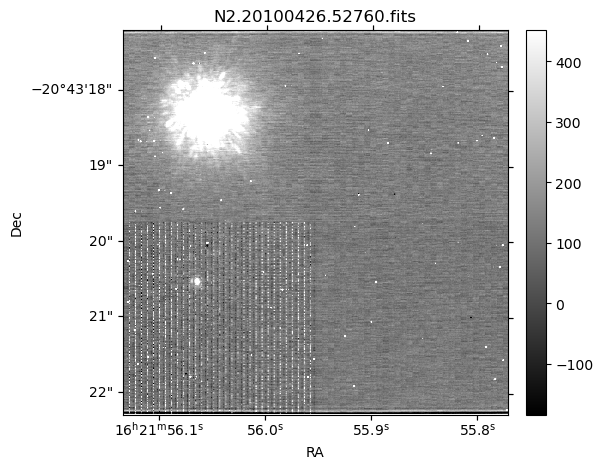

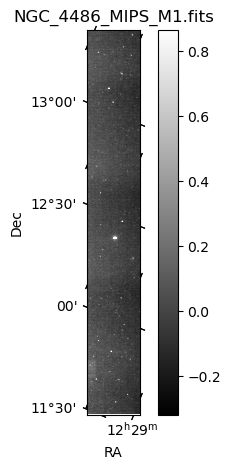

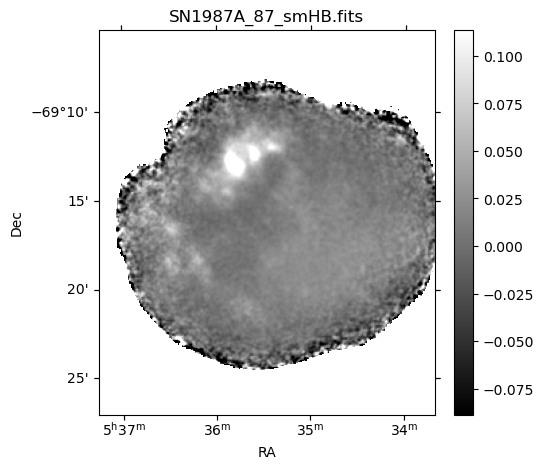

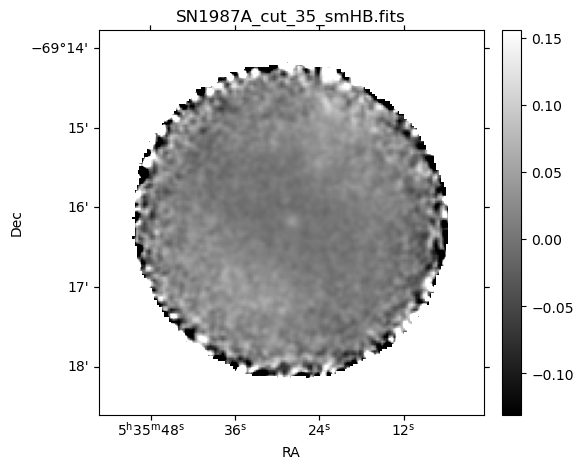

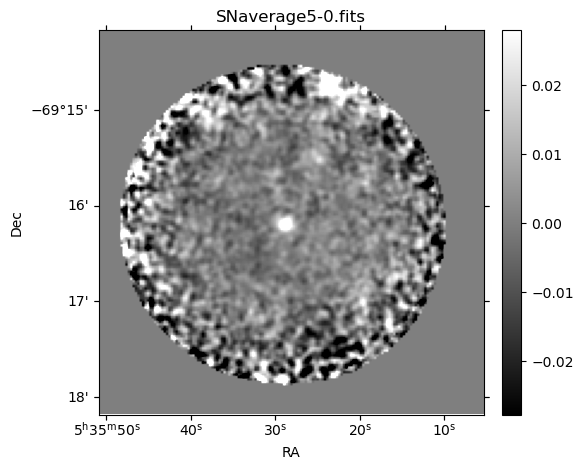

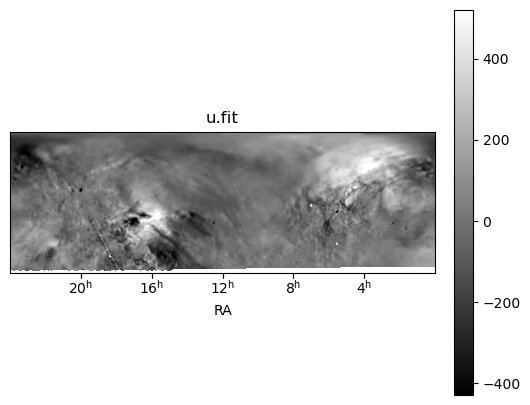

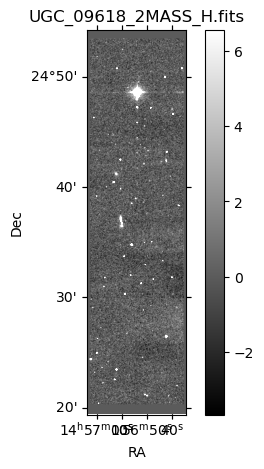

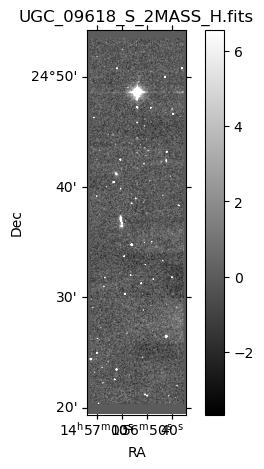

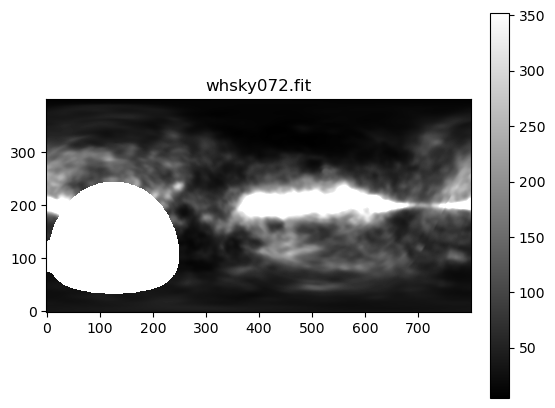

In [6]:
plot_fits_images(path)